# Lab Session #5
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Matthias Inghels, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Constantijn Coppers (02010771)
<br>
<font color=blue>Academic Year:</font> 2023-2024

# Module 3: Brunel network

In this practical, you will simulate a network of sparsely connected identical Leaky-Integrate-and-Fire neurons. 

This model is based on the paper by [Brunel 2000](https://link.springer.com/article/10.1023/A:1008925309027) and is also discussed in [Neuronal Dynamics](http://neuronaldynamics.epfl.ch), see eg. Figure 13.7. 

We will show that a large network of neurons consisting of a group of excitatory and a group of inhibitory neurons that receive external input is capable of producing a rich dynamics. The parameters that we will vary to trigger different states are (1) the driving frequency of the external population and (2) the relative strength of inhibition vs excitation (g). 

To do so, we will follow two strategies both relying on the BRIAN package: the first strategy is to create our own network from scratch. This will allow you to get acquainted with the BRIAN package and will prepare you for the second strategy. Here, you will use a pre-defined spiking network (included in the BRIAN package), but you will have to make sure you understand its input and outputs in order to induce the correct behaviour. 


We start by ensuring all packages are loaded. Make sure to have installed the [Brian Package](https://briansimulator.org/) 

In [1]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools, spike_tools
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

## Step 1.1. Initialising the NeuronGroup instance

We start by defining a NeuronGroup instance. You can find the documentation [here](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.groups.neurongroup.NeuronGroup.html) 

A NeuronGroup instance takes as input the number of neurons, the dynamics of a single neuron 'model', the length of the refractory period and the integration method. Note that initialising the NeuronGroup will not yet run the simulation. Running the simulation will be done in the upcoming blocks once we have added all details to the network. 

The input parameters of the NeuronGroup instance should be: 
- number of neurons: N_Excit (4000) +N_Inhib (1000)
- the model should model the LIF dynamics
- the model should reset at a threshold v = v_reset (10 mV)
- the neurons should have an absolute refractory period (2ms)
- integration method should be linear

What is the default firing threshold? 

In [2]:
# Import neurodynex3 LIF dynamics & check default values
from neurodynex3.brunel_model import LIF_spiking_network

b2.start_scope()

# Define the network parameters
N_Excit = 4000
N_Inhib = 1000

# Define the single neuron model parameters
v_rest = 0*b2.mV
v_reset = 10*b2.mV
abs_refractory_period = 2*b2.ms

firing_threshold = LIF_spiking_network.FIRING_THRESHOLD
membrane_time_scale = LIF_spiking_network.MEMBRANE_TIME_SCALE
# b2.defaultclock.dt = 0.05*b2.ms

# ... and its dynamics
lif_dynamics = """
dv/dt = (v_rest - v)/membrane_time_scale : volt
"""


In [3]:
# Print parameters
print('Default firing threshold:\t', firing_threshold)
print('Default membrane timescale:\t', membrane_time_scale)
# print('Default defaultclok:\t\t', b2.defaultclock.dt)

Default firing threshold:	 20. mV
Default membrane timescale:	 20. ms


In [4]:
# Define the network
network = NeuronGroup(
    N_Excit + N_Inhib, model = lif_dynamics,
    threshold = 'v > firing_threshold', refractory = abs_refractory_period,
    method = 'linear', reset = 'v = v_reset')

print(network)
print(network.v)

NeuronGroup(clock=Clock(dt=50. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
<neurongroup.v: array([0., 0., 0., ..., 0., 0., 0.]) * volt>


<div class="alert alert-success">
<span style="color:black">

**A1.1 Answer** 
    
The default firing threshold is 20 mV.
    
</span>

## Step 1.2. Add network structure
Now that we have created a group of neurons, we will define how they are connected. In order to connect neurons to each other, we first need to distinguish the two neuronal populations (the excitatory and inhibitory population). In order to define the first N_Excit neurons to be excitatory and the remaining part to be inhibitory, you can simply use the following code snippet. 

In [5]:
# Split up the network into excitatory and inhibitory populations
excitatory_population = network[:N_Excit]
inhibitory_population = network[N_Excit:]

Now, we need to define two types of synapses: excitatory and inhibitory synapses. Allow for a synaptic delay of 1.5*b2.ms and use a random connection probability of 0.1. You can find the documentation [here](https://brian2.readthedocs.io/en/stable/user/synapses.html) 
In order to follow the notations in the book, please use following notation and default values: 

What is the "target" network? 

In [6]:
# Connection Parameters
w0 = 0.1 * b2.mV
g = 4.0
J_excit = w0
J_inhib = - g * w0
synaptic_delay = 1.5 * b2.ms
connection_probability = 0.1

In [8]:
# Excitatory Synapses
exc_synapses = Synapses(excitatory_population, target = network, on_pre = "v += J_excit * (rand() < connection_probability)", delay = synaptic_delay)
exc_synapses.connect(p = connection_probability)

# Inhibitory Synapses
inhib_synapses = Synapses(inhibitory_population, target = network, on_pre = "v += J_inhib * (rand() < connection_probability)", delay = synaptic_delay)
inhib_synapses.connect(p = connection_probability)

In [9]:
help(Synapses)

Help on class Synapses in module brian2.synapses.synapses:

class Synapses(brian2.groups.group.Group)
 |  Synapses(source, target=None, model=None, on_pre=None, pre=None, on_post=None, post=None, connect=None, delay=None, on_event='spike', multisynaptic_index=None, namespace=None, dtype=None, codeobj_class=None, dt=None, clock=None, order=0, method=('exact', 'euler', 'heun'), method_options=None, name='synapses*')
 |
 |  Class representing synaptic connections.
 |
 |  Creating a new `Synapses` object does by default not create any synapses,
 |  you have to call the `Synapses.connect` method for that.
 |
 |  Parameters
 |  ----------
 |
 |  source : `SpikeSource`
 |      The source of spikes, e.g. a `NeuronGroup`.
 |  target : `Group`, optional
 |      The target of the spikes, typically a `NeuronGroup`. If none is given,
 |      the same as `source`
 |  model : `str`, `Equations`, optional
 |      The model equations for the synapses.
 |  on_pre : str, dict, optional
 |      The code t

In [10]:
def show_connections(synaps, ax, lcolor = 'black', ls = '-', label = 'Excitatory', N_max = 100):
    # get the source and target neurons
    source, target = synaps.i, synaps.j

    counter = 0
    for i, j in zip(source, target):
        line, = ax.plot([0, 1], [i, j], ls = ls, lw = 1, color = lcolor, label = label)
        counter += 1
        
        if counter > N_max:
            break
    return line

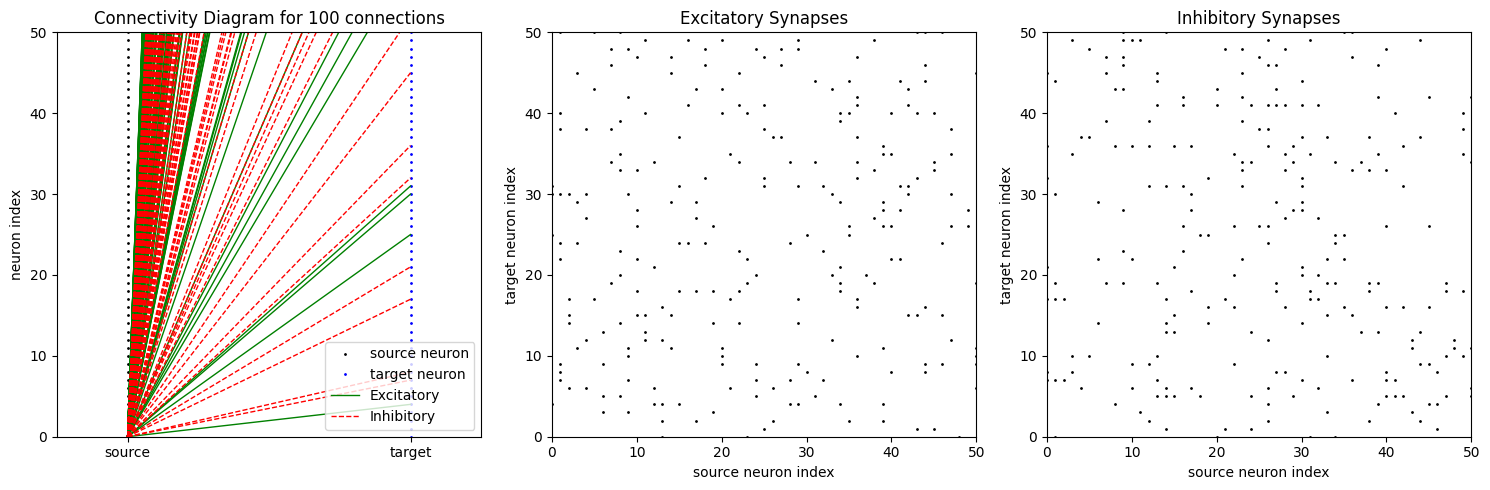

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (5*3, 5))


# plot source and target neuron indices
ax1.set_title('Connectivity Diagram for 100 connections')
line_source, = ax1.plot(np.zeros(N_Excit + N_Inhib), np.arange(N_Excit + N_Inhib), ls = '', marker = 'o', markersize = 1, color = 'black', label = 'source neuron')
line_target, = ax1.plot(np.ones(N_Excit + N_Inhib), np.arange(N_Excit + N_Inhib), ls = '', marker = 'o', markersize = 1, color = 'blue', label = 'target neuron')

# plot the connections
line_ex = show_connections(exc_synapses, ax1, lcolor = 'green')
line_inhib = show_connections(inhib_synapses, ax1, lcolor = 'red', label = 'Inhibitory', ls = '--')

ax1.set_xticks([0, 1], ['source', 'target'])
ax1.set_ylabel('neuron index')
ax1.legend(handles = [line_source, line_target, line_ex, line_inhib], loc = 'lower right')

# plot the relation excitatory sources --> target
ax2.set_title('Excitatory Synapses')
i_ex, j_ex = exc_synapses.i, exc_synapses.j 
ax2.plot(i_ex, j_ex, ls = '', marker = 'o', markersize = 1, color = 'black')

# plot the relation inhibitory sources --> target
ax3.set_title('Inhibitory Synapses')
i_inhib, j_inhib = inhib_synapses.i, inhib_synapses.j 
ax3.plot(np.array(i_inhib), np.array(j_inhib), ls = '', marker = 'o', markersize = 1, color = 'black')

ax1.set_xlim((-0.25, 1.25))
ax1.set_ylim((0, 50))

for ax in (ax2, ax3):
    ax.set_xlim((0, 50))
    ax.set_ylim((0, 50))

    ax.set_xlabel('source neuron index')
    ax.set_ylabel('target neuron index')

plt.tight_layout()
plt.show()


<div class="alert alert-success">
<span style="color:black">

**A1.2 Answer** 
    
The target network is the group of neurons (`NeuronGroup` object) that are targetted by the source neurons (source of spikes). In our case, we have two sources: the excitory neurons and inhibitory neurons which both target the whole network (`network`).

    
</span>

## Step 1.3. Enter external Poisson input
Next, you can excite the network through an externally applied Poisson input, by using [Poisson Input](https://brian2.readthedocs.io/en/stable/reference/brian2.input.poissoninput.PoissonInput.html). Start with N = 1000 external Poisson neurons at an input rate of 13 Hz with a connectivity strength w = w0. 



In [12]:
# Define PoissonInput parameters
poisson_input_rate = 13 * b2.Hz
N_extern = 1000
w_external = w0

In [13]:
# Initialize PoissonInput instance
external_poisson_input = PoissonInput(target = network, target_var = 'v', N = N_extern, rate = poisson_input_rate, weight = w_external)

## Step 1.4. Add monitors 
In the final step before running the simulation we will add some monitors that allows us to assess the simulated network once the simulation has finished. In order to do so, we will monitor a random selection of 100 neurons and the use the [PopulationRateMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html), [SpikeMonitor](https://brian2.readthedocs.io/en/2.0rc/reference/brian2.monitors.ratemonitor.PopulationRateMonitor.html) and [StateMonitor](https://brian2.readthedocs.io/en/stable/reference/brian2.monitors.statemonitor.StateMonitor.html). 

Sample 200 of all neurons involved. 

In [14]:
# set random seed
# random.seed(123)

# select random subset of neurons to be monitored
monitored_subset_size = 200
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)

In [15]:
# rate_monitor: records instantaneous firing rates, averaged across the neurons of the NeuronGroup
rate_monitor = PopulationRateMonitor(network)

# spike_monitor: records spikes from the NeuronGroup
spike_monitor = SpikeMonitor(network, record = idx_monitored_neurons)

# voltage_monitor: records values of the state variable v during a simulation
voltage_monitor = StateMonitor(network, 'v', record = idx_monitored_neurons)

## Step 1.5. Run the simulation
Run the simulation for a total simulated time of 500 ms using the following line of code. Describe what is plotted. 


In [16]:
sim_time = 500.*b2.ms
b2.run(sim_time)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'v += J_excit * (rand() < connection_probability) (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'v += J_inhib * (rand() < connection_probability) (in-place)'
 [brian2.codegen.generators.base]


INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


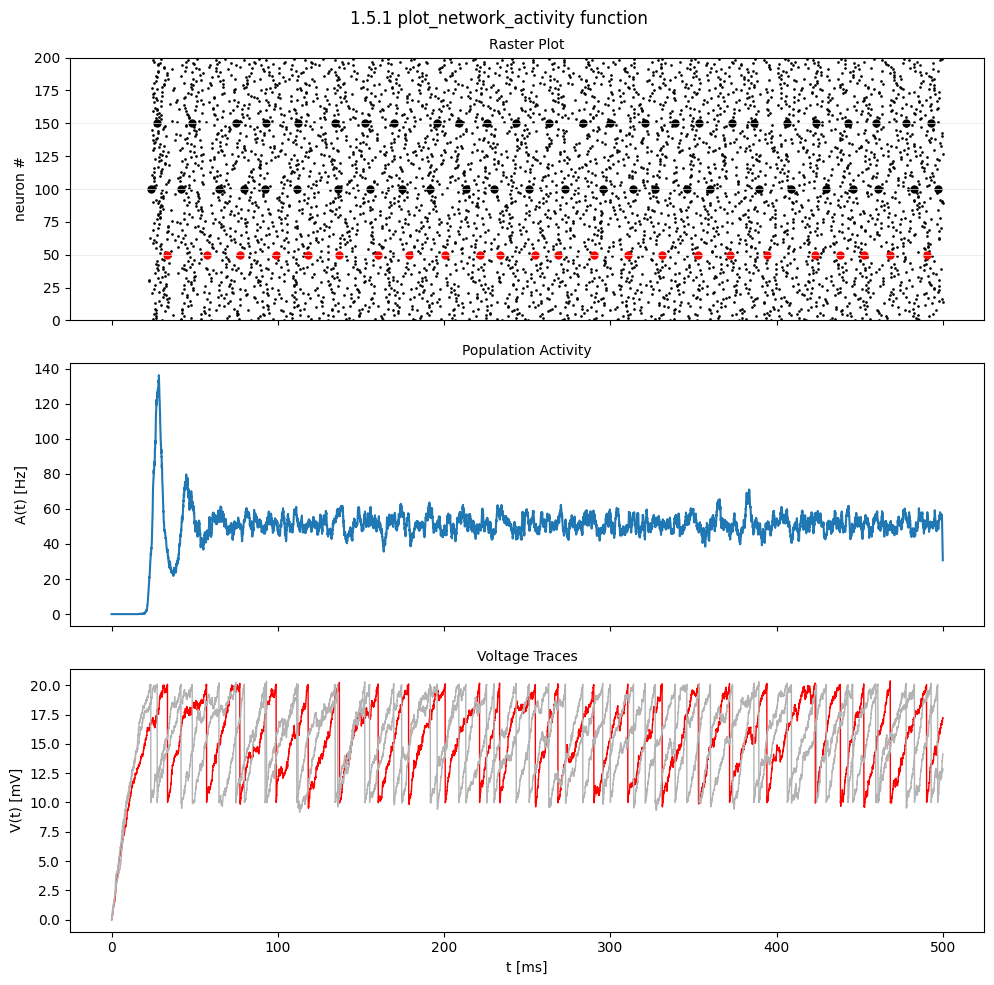

In [17]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list = idx_monitored_neurons,\
                                 t_min = 0 * b2.ms, t_max = sim_time,
                                 figure_size=(10, 10))

# plt.xlim(0, 500)
plt.suptitle(r'1.5.1 plot_network_activity function')
plt.tight_layout()
plt.show()

Access the data in rate_monitor, spike_monitor, voltage_monitor

First, describe what is described in rate_monitor.rate. Use the smooth_rate function (flat window) to the outputted rates. Make sure to only include the last 150 ms of your simulation. Plot the smoothed_rate in function of time and calculate the mean of the rate across this time window. 

You can the time axis from rate_monitor.t

In [18]:
ts = rate_monitor.t / b2.ms
t_min = 350; t_max = 500 

In [19]:
idx_rate = np.where((t_min <= ts) & (ts < t_max))
print(rate_monitor.rate)

<ratemonitor.rate: array([ 0.,  0.,  0., ..., 64., 68., 40.]) * hertz>


Now, vary the window width across which the rate is averaged and write down your observations (do plot!). 



INFO       width adjusted from 0.5 ms to 0.55 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 5. ms to 5.05 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 20. ms to 20.05 ms [brian2.monitors.ratemonitor.adjusted_width]


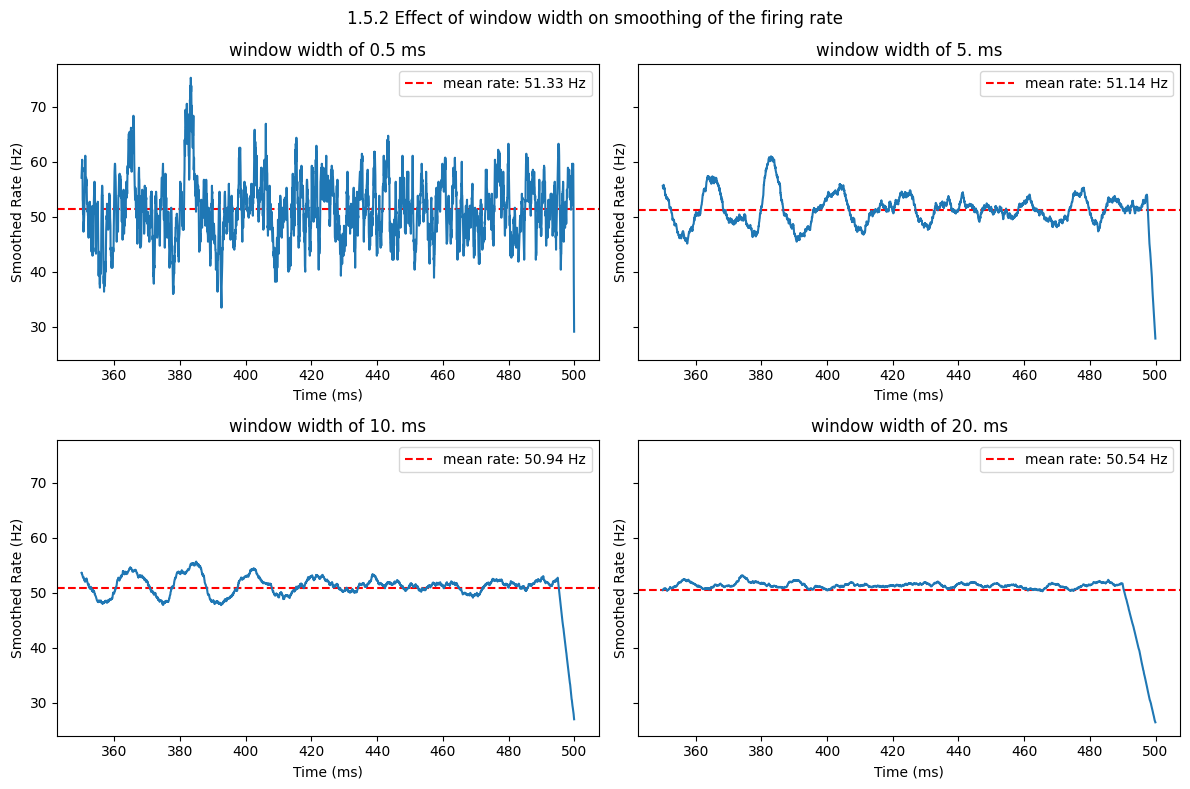

In [20]:
window_widths = [0.5, 5, 10, 20] * b2.ms

fig, axs = plt.subplots(2, 2, figsize = (12, 4*2), sharey = True)
fig.suptitle('1.5.2 Effect of window width on smoothing of the firing rate')

for i in range(0, 4):
    smoothed_rates = rate_monitor.smooth_rate(window = "flat", width = window_widths[i]) / b2.Hz

    mean_rate = np.mean(smoothed_rates[idx_rate])
    axs[i//2, i%2].axhline(y = mean_rate, color = 'red', ls = '--', label = f'mean rate: {mean_rate:.2f} Hz')
    axs[i//2, i%2].plot(ts[idx_rate], smoothed_rates[idx_rate])
    
    axs[i//2, i%2].set_xlabel('Time (ms)')
    axs[i//2, i%2].set_ylabel('Smoothed Rate (Hz)')
    axs[i//2, i%2].set_title(f'window width of {window_widths[i]}')

    axs[i//2, i%2].legend()

plt.tight_layout()
plt.show()

Now, study what is saved in spike_monitor. Start by creating eventtrains. What is the mean time between two subsequent spikes?  

In [21]:
eventtrains = spike_monitor.event_trains()

ISIs = []
for train in eventtrains.values():
    ISI = np.diff(train)
    if len(ISI) > 1:
        ISIs.append(np.array(ISI / b2.ms).mean())

ISIs = np.array(ISIs)
print(len(ISIs))

5000


In [22]:
mean = ISIs.mean()
print(f"Mean time between two subsequent spikes: {mean:.2f} ms")

Mean time between two subsequent spikes: 19.52 ms


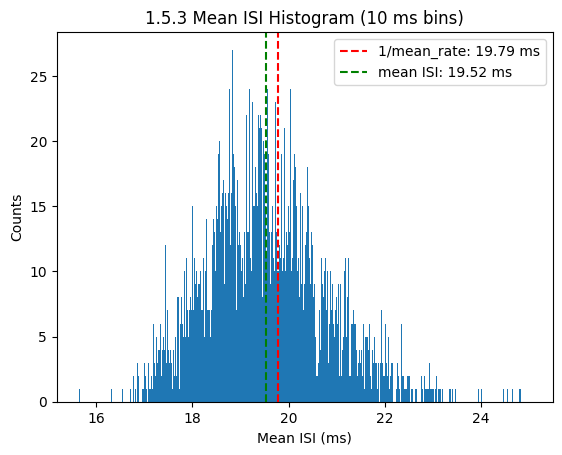

In [23]:
dt = 1e-2
bin_edges = np.arange(ISIs.min(), np.percentile(ISIs, 100), dt) 

plt.figure()

plt.hist(ISIs, bin_edges)         

plt.axvline(x = 1 / mean_rate * 1e3, color = 'red', ls = '--', label = f'1/mean_rate: {1 / mean_rate*1e3:.2f} ms')
plt.axvline(x = mean, color = 'green', ls = '--', label = f'mean ISI: {mean:.2f} ms')

plt.ylabel('Counts')
plt.xlabel('Mean ISI (ms)')
plt.title('1.5.3 Mean ISI Histogram (10 ms bins)')    

plt.legend()
plt.show()

<div class="alert alert-success">
<span style="color:black">

**A1.5 Answer** 
    
The function `plot_network_activity()` offers a visualization of the simulation results, focusing on the 200 monitored neurons within the network. Plot 1.5.1 displays a dot-raster plot illustrating the spike trains of the monitored neurons, the network activity $A(t)$, and voltage traces of selected neurons. Notice that the red color in the bottom plot and top panel corresponds to the same neuron, as does the relationship between black dots and gray lines.

The `rate_monitor.rate` instance provides insight into the averaged instantaneous firing rate across all neurons in the network for each time point during the simulation.

Plot 1.5.2 showcases the averaged firing rate using varying time windows: 0.5, 5, 10, and 20 ms. Analysis reveals that a 0.5 ms window width exhibits numerous high-frequency oscillations, hindering the observation of a clear pattern in the firing rate. Conversely, setting the window width to 5 ms and 10 ms reveals clear oscillatory behavior around the mean firing rate, enabling us to see a clear pattern in the temporal evolution of the firing rate. Increasing the window width to 20 ms yields a relatively straight line, indicating the mean firing rate. The mean firing rate is approximately 51 Hz.

The selection of a window width involves a trade-off between capturing high-frequency information (small window width) and discerning an overall trend in the signal (larger window width). As the window width increases, high-amplitude values are averaged out, leading to a decrease in overall amplitude.

The spike_monitor object records spikes from the monitored neurons, accessible via the `spike_trains()`-method, which returns a dictionary mapping neuron indices to spike trains. These spike trains are further utilized to calculate the mean ISI.

Figure 1.5.3 presents the distribution of mean ISIs, confirming that the calculated mean ISI aligns closely with the inverse of the mean firing frequency, as expected.

</span>

# 2. The pre-implemented Brunel network

Import the LIF_spiking_network function from neurodynex3.brunel_model and use this function to simulate a network consisting of 10000 excitatory neurons, 2500 inhibitory neurons and 1000 external neurons. 

Further, 
- w0 = 0.1 mV
- total simulated time of 500 ms
- the membrane time scale can be put to default (LIF_spiking_network.MEMBRANE_TIME_SCALE)
- the same goes for the firing threshold (LIF_spiking_network.FIRING_THRESHOLD)
- monitored_subset = 50
- synaptic delay is 1.5ms 

We will vary two parameters: g (an input parameter to simulate_brunel_network) and, second, the firing frequency of the external neurons $\nu_{extern}$. The latter should be expressed as a ratio multiplied with $\nu_{threshold}$. The frequency $\nu_{threshold}$ is the minimal poisson rate in the external neuronal population required to elicit firing in the network in the absence of any feedback. 

According to Brunel (2000), $\nu_{threshold}$ can be calculated as: 

\begin{align}
\nu_{threshold} &= \frac{\theta}{N_{extern}w_0\tau_m}
\end{align}

Does this expression make sense? 

For starters, you can use g=6 and $\nu_{extern} = 4\nu_{threshold}$

Calculate $\nu_{threshold}$ in function of the parameters mentioned above and the corresponding $\nu_{extern}$. And run the simulation. Make sure to output rate_monitor, spike_monitor, voltage_monitor and monitored_spike_idx.

Make sure to start each simulation with a "b2.start_scope()" statement. 

In [24]:
from neurodynex3.brunel_model import LIF_spiking_network
b2.start_scope()

N_Excit = 10000
N_Inhib = 2500
N_extern = 1000

w0 = 0.1 * b2.mV
sim_time = 500 * b2.ms
monitored_subset_size = 50
SYNAPTIC_DELAY = 1.5 * b2.ms
g = 6

nu_threshold = LIF_spiking_network.FIRING_THRESHOLD / (N_extern * w0 * LIF_spiking_network.MEMBRANE_TIME_SCALE)
nu_extern = 4 * nu_threshold

print(f"nu_threshold =\t{nu_threshold} \nnu_extern =\t{nu_extern}")

nu_threshold =	10. Hz 
nu_extern =	40. Hz


In [25]:
rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = \
    LIF_spiking_network.simulate_brunel_network(N_Excit = N_Excit, N_Inhib = N_Inhib, N_extern = N_extern, w0 = w0, sim_time = sim_time,
                                                monitored_subset_size = monitored_subset_size, g = g, poisson_input_rate = nu_extern)

Plot the output using "plot_network_activity", make sure to add the "t_min" and "t_max" parameter and increase the figure size to figure_size=(10,10). 

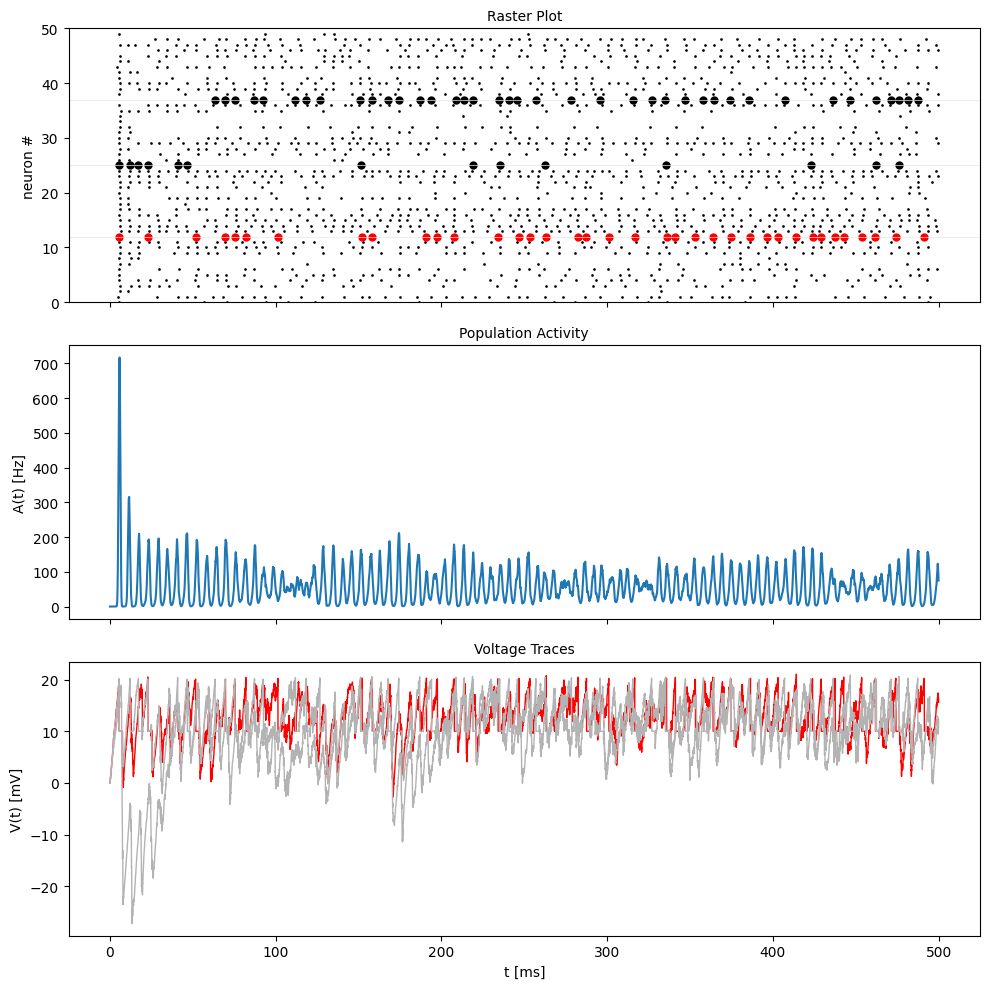

In [26]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list = monitored_spike_idx,\
                                 t_min = 0 * b2.ms, t_max = sim_time,\
                                 figure_size=(10, 10))

plt.tight_layout()
plt.show()

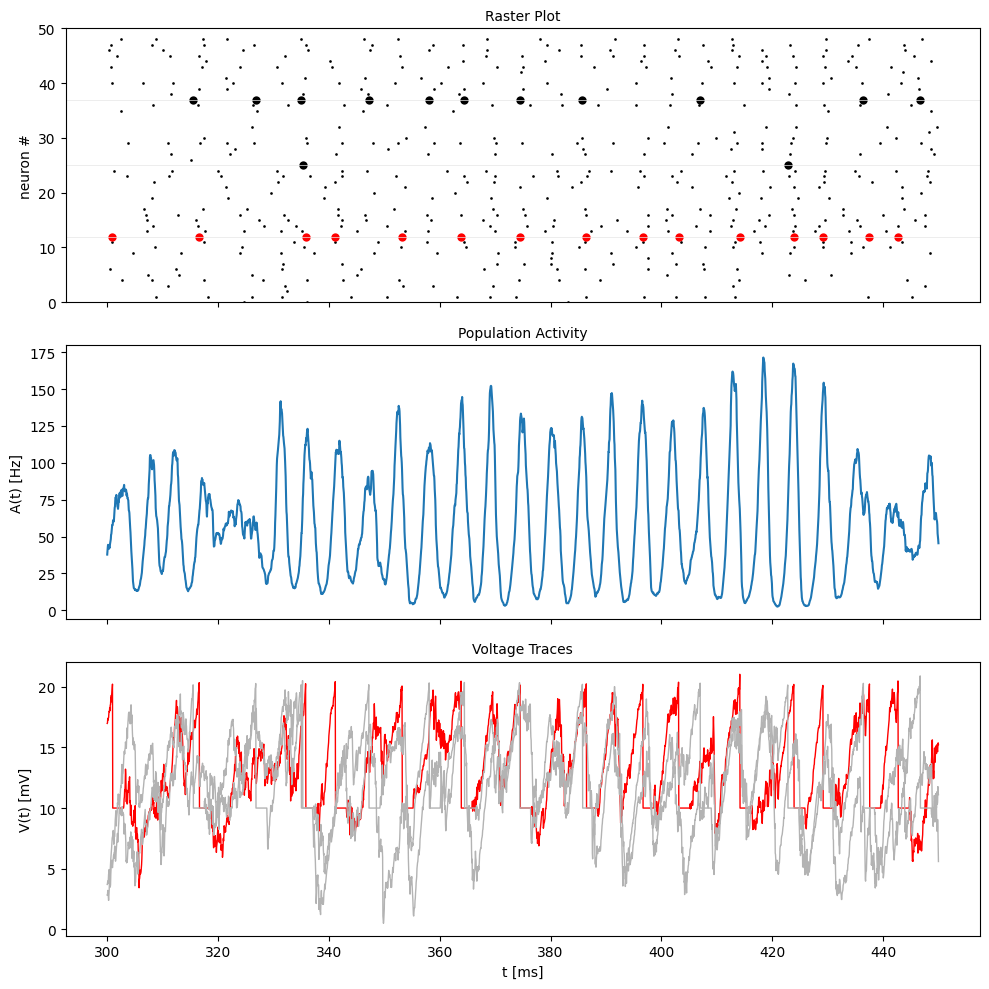

In [27]:
plot_tools.plot_network_activity(rate_monitor, spike_monitor, \
                                 voltage_monitor, spike_train_idx_list=monitored_spike_idx,\
                                 t_min = 300 * b2.ms, t_max = 450 * b2.ms,\
                                 figure_size=(10, 10))

plt.tight_layout()
plt.show()

The first output to analyse is the rate_monitor. 
Plot - for different choices of window width (0.5, 5, 20) ms - the smoothed_rates and calculate the mean of smoothed_rate across a time window (e.g. between 300 and 450 ms). How does this compare to Table 1 in Brunel (2000)? 


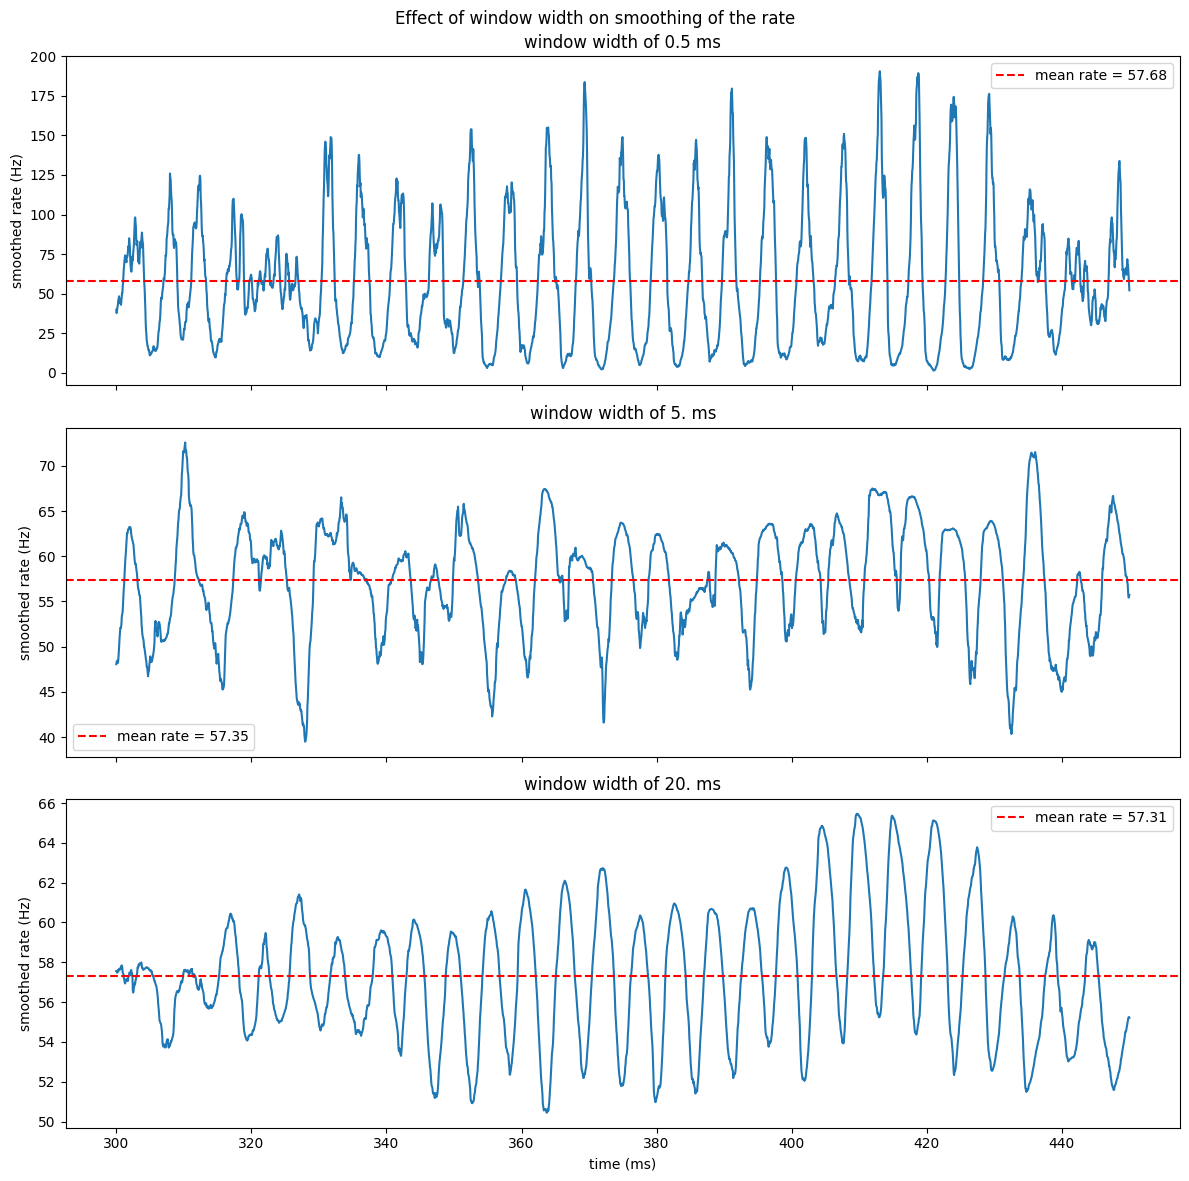

In [28]:
# Get time axis
t = rate_monitor.t / b2.ms
t_min, t_max = 300, 450
idx_rate = (t_min <= ts) * (ts <= t_max)

# Investigate the effect window width on smoothing of the rate
window_widths = [0.5, 5, 20]*b2.ms

fig, axs = plt.subplots(3, 1, figsize = (12, 4 * len(window_widths)), sharex = True)
fig.suptitle('Effect of window width on smoothing of the rate')

for i, window in enumerate(window_widths):
    smoothed_rates = rate_monitor.smooth_rate(window="flat", width=window)/b2.Hz
    
    axs[i].plot(ts[idx_rate], smoothed_rates[idx_rate])

    mean_rate = np.mean(smoothed_rates[idx_rate])
    axs[i].axhline(y = mean_rate, color = 'red', ls = '--', label = f'mean rate = {mean_rate:.2f}')

    axs[i].set_ylabel('smoothed rate (Hz)')
    axs[i].set_title(f'window width of {window}')

    axs[i].legend()

axs[-1].set_xlabel('time (ms)')

plt.tight_layout()
plt.show()

Next, we want to assess the global frequency content in rate_monitor. We know that if we have a time signal of 0.5 seconds, the maximal frequency resolution is 2 Hz. Be aware that Welch' method as implemented will chop the data in different pieces (to enable the averaging of the spectrum) yielding a smaller frequency resolution.  

Start by smoothing the rate with a window of 0.5 ms and calculate the spectrum using [signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). What is the sampling frequency fs? 

Plot the spectrum. What is the frequency resolution (look at np.diff(f)[0]). Can you explain how signal.welch arrives at this frequency resolution if you know that it - by default - includes 256 samples and if you check the integration time constant (typically 0.05 ms, but check b2.defaultclock.dt) that you used for the simulation? 

What happens if you impose nperseg = 256*8? 

What happens if you impose nfft = 10000 ? (Answer: you interpolate the spectrum). 

In [29]:
# Smoothing the rate
smoothed_rates = rate_monitor.smooth_rate(window = "flat", width = 0.5 * b2.ms) / b2.Hz

# calculating the spectra
from scipy import signal
fs = 1 / (np.diff(ts)[0] * 1e-3)
f, X = signal.welch(smoothed_rates, fs = fs) #nperseg = 256*8, nfft = 10000)
f2, X2 = signal.welch(smoothed_rates, fs = fs, nperseg = 256*8) #, nfft = 10000)
f3, X3 = signal.welch(smoothed_rates, fs = fs, nfft = 10000)
f4, X4 = signal.welch(smoothed_rates, fs = fs, nperseg = 256*8, nfft = 10000)

# check integration time constant
print(f"Integration time constant: {b2.defaultclock.dt}")

# sampling frequencies
print(f"Sampling frequency: {fs:.2f} Hz")

# frequency resolutions
f_res = [np.diff(fi)[0] for fi in [f, f2, f3, f4]]
print(f"Frequency resolution: {f_res} Hz")

vals = [(f, X), (f2, X2), (f3, X3), (f4, X4)]

Integration time constant: 50. us
Sampling frequency: 20000.00 Hz
Frequency resolution: [78.125, 9.765625, 2.0, 2.0] Hz


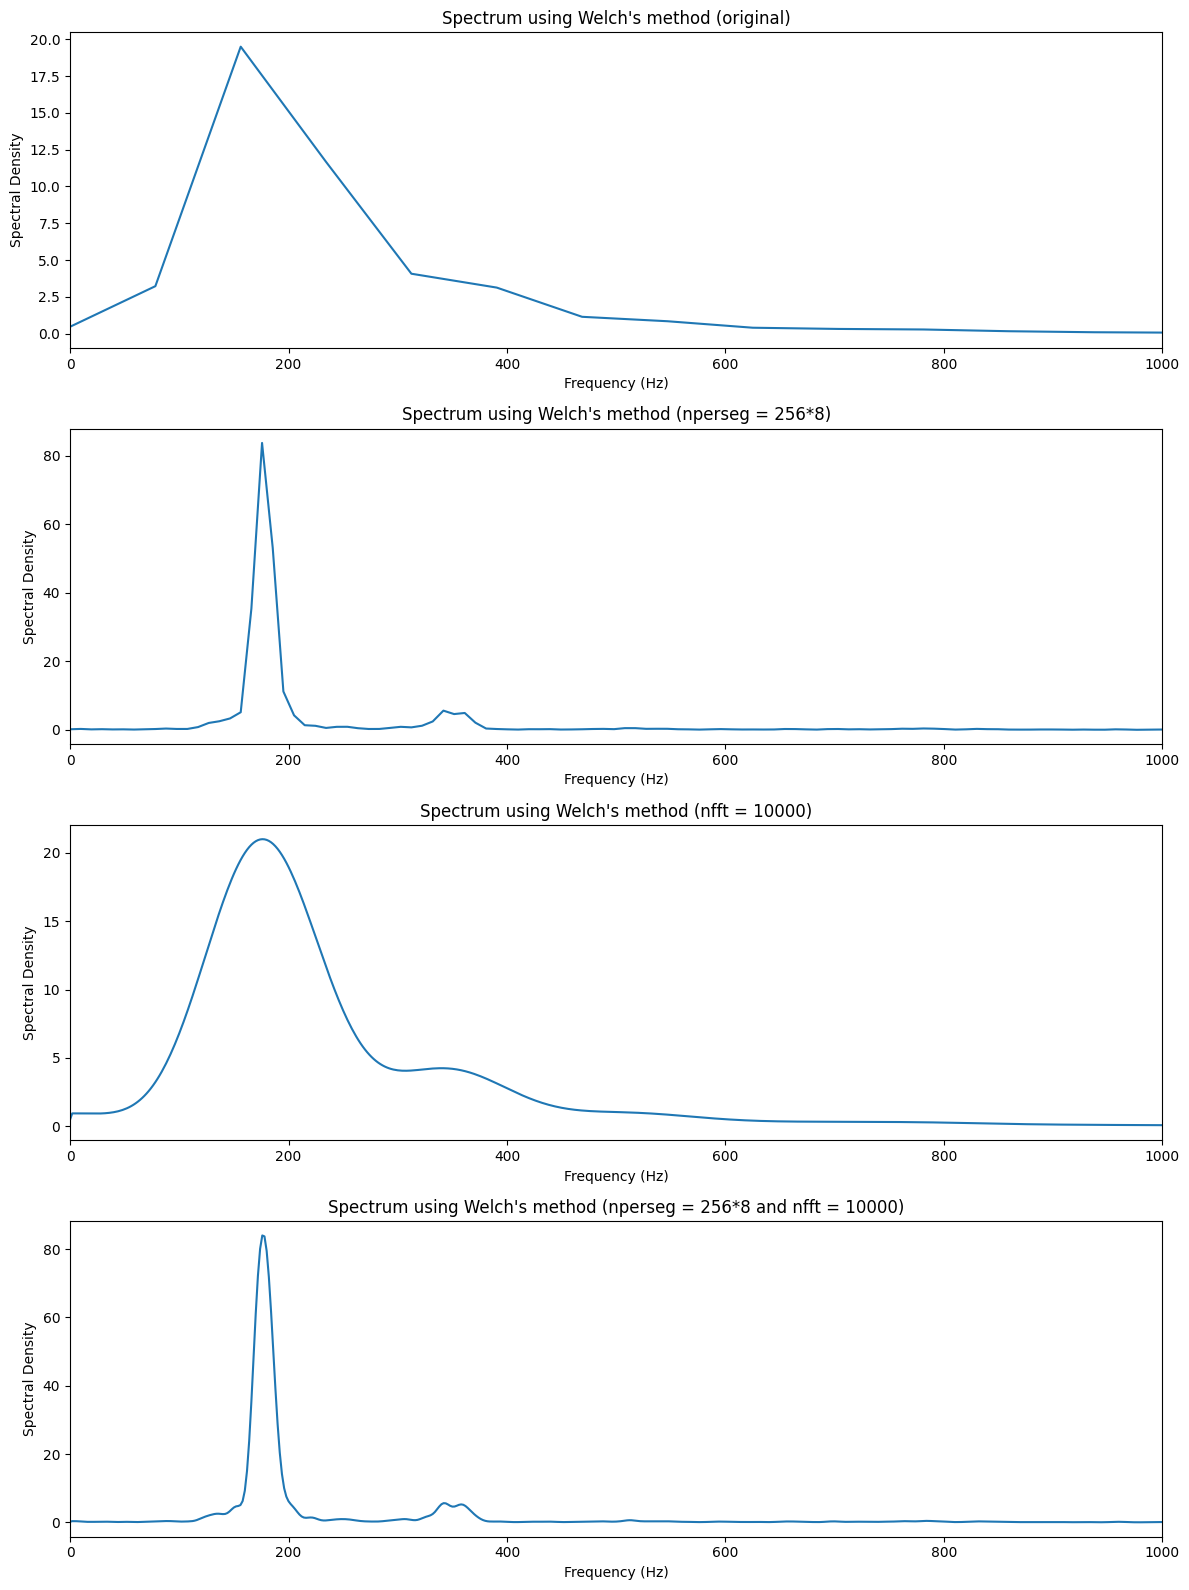

In [30]:
# plot the spectra
fig, ax = plt.subplots(4, 1, figsize = (12, 4 * 4))

labels = ['original', 'nperseg = 256*8', 'nfft = 10000', 'nperseg = 256*8 and nfft = 10000']

for i, axi in enumerate(ax):
    axi.set_ylabel('Spectral Density')
    axi.set_xlabel('Frequency (Hz)')
    axi.set_title(f'Spectrum using Welch\'s method ({labels[i]})')

    axi.plot(vals[i][0], vals[i][1])

    axi.set_xlim((0, 1000))


plt.tight_layout()
plt.show()

We will now use the machinery provided by BRIAN to calculate and plot the power spectrum. BRIAN takes a slightly different approach. BRIAN starts from a desired frequency resolution, a desired number of windows over which the spectrum should be averaged and an initial time segment that should be ignored. Based on these desiredata, the minimal simulation length is calculated. 

Example: if we want a frequency resolution of 5 Hz, we need time windows of 200 ms. If we assume non-overlapping time windows and a number of averages the total simulated signal should be k*200ms. 

In this case, we have simulated 0.5 seconds of data. If we aim for an initial segment to be removed of 99ms and a frequency resolution of 10 Hz, what is then the maximal number of windows we can include? 

In [31]:
# Adjusted version of (corrupted) get_population_activity_power_spectrum() method
def get_population_activity_power_spectrum(
        rate_monitor, delta_f, k_repetitions, T_init=100*b2.ms, subtract_mean_activity=False):
    """
    Computes the power spectrum of the population activity A(t) (=rate_monitor.rate)

    Args:
        rate_monitor (RateMonitor): Brian2 rate monitor. rate_monitor.rate is the signal being
            analysed here. The temporal resolution is read from rate_monitor.clock.dt
        delta_f (Quantity): The desired frequency resolution.
        k_repetitions (int): The data rate_monitor.rate is split into k_repetitions which are FFT'd
            independently and then averaged in frequency domain.
        T_init (Quantity): Rates in the time interval [0, T_init] are removed before doing the
            Fourier transform. Use this parameter to ignore the initial transient signals of the simulation.
        subtract_mean_activity (bool): If true, the mean value of the signal is subtracted. Default is False

    Returns:
        freqs, ps, average_population_rate
    """
    data = rate_monitor.rate/b2.Hz
    delta_t = rate_monitor.clock.dt
    f_max = 1./(2. * delta_t)
    N_signal = int(2 * f_max / delta_f)
    T_signal = N_signal * delta_t
    N_init = int(T_init/delta_t)
    N_required = k_repetitions * N_signal + N_init
    N_data = len(data)

    # print("N_data={}, N_required={}".format(N_data,N_required))
    if (N_data < N_required):
        err_msg = "Inconsistent parameters. k_repetitions require {} samples." \
                  " rate_monitor.rate contains {} samples.".format(N_required, N_data)
        raise ValueError(err_msg)
    if N_data > N_required:
        # print("drop samples")
        data = data[:N_required]
    # print("length after dropping end:{}".format(len(data)))
    data = data[N_init:]
    # print("length after dropping init:{}".format(len(data)))
    average_population_rate = np.mean(data)
    if subtract_mean_activity:
        data = data - average_population_rate
    average_population_rate *= b2.Hz
    data = data.reshape(k_repetitions, N_signal)  # reshape into one row per repetition (k)
    k_ps = np.abs(np.fft.fft(data))**2
    ps = np.mean(k_ps, 0)
    # normalize
    ps = ps * delta_t / N_signal  # TODO: verify: subtract 1 (N_signal-1)?
    freqs = np.fft.fftfreq(N_signal, delta_t)
    ps = ps[:int((N_signal/2))]
    freqs = freqs[:int((N_signal/2))]
    return freqs, ps, average_population_rate

In [32]:
delta_f = 10*b2.Hz
k = 4
T_init = 99*b2.ms + b2.defaultclock.dt; 
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_monitor, delta_f, k, T_init)

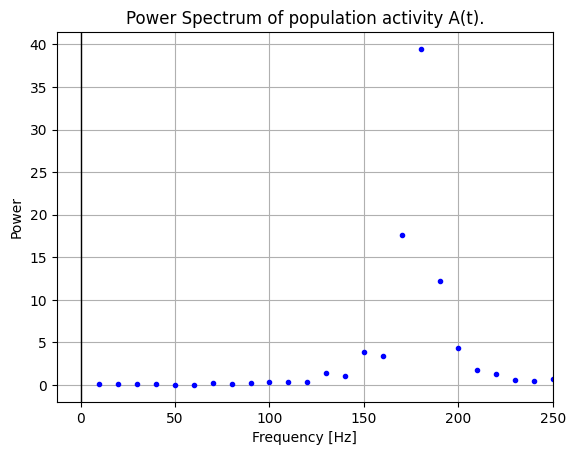

In [33]:
# Plot population activity PS
plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, 250 *b2.Hz, None)
plt.show()

<div class="alert alert-success">
<span style="color:black">

**2 Answer** 

The expression for $\nu_{\text{threshold}}$ is logically as it establishes a relationship between the threshold firing rate 
$\nu_{\text{threshold}}$ of a neuron and the external input it receives. This relationship considers the number of external inputs $N_{\text{extern}}$, the strength of the synapses $w_0$, and the membrane time constant $\tau_m$. The parameter $\theta$ represents the firing threshold. This derivation is based on the assumption that the neuron receives input from a large number of other neurons, and that the input is weak and uncorrelated.

---

Similar to the findings in the previous exercise, the network activity plots exhibit the expected behavior. The mean time between spikes appears to be slightly less than 20 ms, as can be visaully observed from the raster plot. A smoothed rate with a window width of 5 ms provides the most accurate results, for the same reasons mentioned in the previous exercise. During the investigated period of 300 to 450 ms, clear peaks in the rate are observed, with an average interval of 15 - 20 ms between each.

When comparing the results to those of the previous exercise, it is evident that the rate follows a less oscillatory shape in the simulation with the pre-implemented Brunel network (in contrast to the first approach).

---

To calculate the spectrum, we first smooth the rate with a window of 0.5 ms, and then utilize the `signal.welch` function to compute the power spectral density (PSD). The default value of `nperseg` is 256, indicating that the signal is segmented into 256 samples before computing the spectrum. Here, the integration time constant (`b2.defaultclock.dt`) used for the simulation is 0.05 ms, resulting in a sampling frequency of 1/0.05 = 20 000  Hz.

The frequency resolution of the spectrum can be calculated using, 

$$
\Delta f = \frac{f_s}{N}\tag{1},
$$

where $N$ is the number of samples in each segment. Thus, for the default `nperseg` value of 256, the frequency resolution is 
$$ 
\Delta f = \frac{20 000}{256} = 78.13 / \text{Hz}
$$
Increasing nperseg to $256\times 8$ would decrease $\Delta f$ to 9.77 Hz, resulting in a higher frequency resolution.

Setting `nfft` to 10 000 would set the length of the FFT used to compute the spectrum to 10 000, which is larger than the default `nperseg` value. This would interpolate the spectrum (zero-padding), theoretically resulting in a lower frequency resolution of 2 Hz. However, this does not provide additional information about the spectrum compared to the first case (`nperseg`=256). Instead, the graphical representation is smoothed out to yield a visually appealing plot, enhancing the interpretability of the spectrum. Increasing `nfft` (i.e. zero-padding) does not add any information but improves the visualization.

---

To calculate the power spectrum using the brian package, we need to choose the number of windows or segments to chop the data into. In this case, we have simulated 0.5 seconds of data. We aim for an initial segment to be removed of 99 ms and a frequency resolution of 10 Hz.
Taking these parameters into account, the maximal number of windows is $k=4$, based on the following reasoning:

The simulation time was originally 500 ms, but the first 99 ms are not used, leaving us with 401 ms of data. We want a frequency resolution of 10 Hz, which corresponds to time windows of 100 ms. The number of windows is calculated as: 

$$
k = \frac{\Delta t_{\text{sim}}}{\Delta t_{\text{window}}} = \frac{401}{100} \approx 4.
$$
Therefore, to calculate the power spectrum with a frequency resolution of 10 Hz using the brian package, we need to chop the data into four windows of 100 ms each.
</span>

## 3 Explore the dynamics. 
Repeat the steps in ##2 for the following set of parameters: 

(A) g = 3, $\nu_{extern}/\nu_{threshold} = 2$ 

(B) g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

(C) g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

Describe what you observe.

In [34]:
from scipy.signal import welch

class DynamicsExplorer:

    def __init__(self, g, nu_extern):
        b2.start_scope()
        # Parameters to be changed
        self.g, self.nu_extern = g, nu_extern
        
        # Nuber of each neuron group
        self.N_Excit, self.N_inhib, self.N_extern = 10000, 2500, 1000
        
        # Model parameters
        self.w0 = 0.1 * b2.mV

        # Simulation parameters
        self.sim_time = 500 * b2.ms
        self.monitored_subset_size = 50

        self.window_widths = [0.5,5,20] * b2.ms
        
    def simulate(self):
        self.rate_monitor, self.spike_monitor, self.voltage_monitor, self.monitored_spike_idx = \
        LIF_spiking_network.simulate_brunel_network(N_Excit = self.N_Excit, N_Inhib = self.N_inhib, N_extern = self.N_extern,
                                                    w0 = self.w0, sim_time = self.sim_time,
                                                    monitored_subset_size = self.monitored_subset_size, g = self.g, 
                                                    poisson_input_rate = self.nu_extern)
    def show_simulation(self, t_min = 300*b2.ms, t_max = 450*b2.ms):
        plot_tools.plot_network_activity(self.rate_monitor, self.spike_monitor, \
                                    self.voltage_monitor, spike_train_idx_list = self.monitored_spike_idx,\
                                    t_min = t_min, t_max = t_max,\
                                    figure_size = (12, 4*3))
        plt.tight_layout()
        plt.show()


    def show_smoothed_rate(self, tmin = 300, tmax = 450 ):
        self.ts = self.rate_monitor.t / b2.ms
        idx_rate = (t_min <= ts) * (ts < t_max)
        
    
        fig, axs = plt.subplots(3, 1, figsize = (12, len(self.window_widths)*4), sharex = True)
        fig.suptitle('Effect of window width on Firing Rate')

        for i, window in enumerate(self.window_widths):
            smoothed_rates = self.rate_monitor.smooth_rate(window = "flat", width = window) / b2.Hz
            axs[i].plot(ts[idx_rate], smoothed_rates[idx_rate])
            
            mean_rate = np.mean(smoothed_rates[idx_rate])
            axs[i].axhline(y = mean_rate, color = 'red', ls = '--', label = f'mean rate = {mean_rate:.2f}')
            
            axs[i].set_ylabel('Firing Rate (Hz)')
            axs[i].set_title(f'window width of {window}')
            axs[i].legend()

        axs[-1].set_xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()

    def get_spectrum(self, width = 0.5*b2.ms):
        # Smooth rate (window = 0.5 ms)
        self.smoothed_rates = self.rate_monitor.smooth_rate(window = "flat", width = width) / b2.Hz
        self.Fs = 1 / (self.ts[1] - self.ts[0]) * 1e3 

        # Calculate spectrum (welch method)
        self.freqs, self.smoothed_rates_spectrum = welch(self.smoothed_rates, fs = self.Fs)
        self.freq_res = np.diff(self.freqs)[0]

        self.freqs_nperseg, self.smoothed_rates_spectrum_nperseg = welch(self.smoothed_rates, fs = self.Fs, nperseg = 256*8)
        self.freq_res_nperseg = np.diff(self.freqs_nperseg)[0]

        self.freqs_nfft, self.smoothed_rates_spectrum_nfft = welch(self.smoothed_rates, fs = self.Fs, nfft = 10000)
        self.freq_res_nfft = np.diff(self.freqs_nfft)[0]

        self.freqs_X, self.smoothed_rates_X = welch(self.smoothed_rates, fs = self.Fs, nperseg = 256*8, nfft = 10000)
        self.freq_res_X = np.diff(self.freqs_X)[0]

    def get_freqres(self):
         print(f"""
Sampling frequency fs\t\t= {self.Fs} Hz
Integration time constant\t= {b2.defaultclock.dt}
--------------------------------------------------------------
Welch frequency resolution\t\t\t= {self.freq_res} Hz
Welch frequency resolution (nperseg=256*8)\t= {self.freq_res_nperseg} Hz
Welch frequency 'resolution' (nfft=10000)\t= {self.freq_res_nfft} Hz
Welch frequency 'resolution' (nperseg=256*8 & nfft=10000)\t= {self.freq_res_X} Hz
""")
        
    def show_PSD(self, f_lim = 1000):
        # Plots: effect of changing parameters in welch method
        fig, axs = plt.subplots(4, 1, figsize = (12, 4 * 4), sharex = True)

        axs[0].plot(self.freqs, self.smoothed_rates_spectrum)
        axs[1].plot(self.freqs_nperseg, self.smoothed_rates_spectrum_nperseg)
        axs[2].plot(self.freqs_nfft, self.smoothed_rates_spectrum_nfft)
        axs[3].plot(self.freqs_X, self.smoothed_rates_X)
        
        fig.suptitle('Effect of changing parameters in Welch method on the Power Spectral Density (PSD)')
        axs[-1].set_xlabel('Frequency (Hz)')

        axs[0].set_title('Standard Welch method')
        axs[1].set_title('nperseg = 256*8')
        axs[2].set_title('nfft = 10 000')
        axs[3].set_title('nperseg = 256*8 & nfft = 10 000')
        
        for ax in axs:
            ax.set_ylabel('PSD')
            ax.set_xlim((0, f_lim))

        plt.tight_layout()
        plt.show()

    def get_population_activity(self, f_lim = 600):
         # Compute population activity PSD
        delta_f = 10*b2.Hz
        k = 4
        T_init = 99 * b2.ms + b2.defaultclock.dt
        pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(self.rate_monitor, delta_f, k, T_init)

        # Plot population activity
        plot_tools.plot_population_activity_power_spectrum(pop_freqs, pop_ps, f_lim * b2.Hz, None)
        plt.show()

## A : g = 3, $\nu_{extern}/\nu_{threshold} = 2$

In [35]:
g = 3
nu_threshold = LIF_spiking_network.FIRING_THRESHOLD / (N_extern * w0 * LIF_spiking_network.MEMBRANE_TIME_SCALE)
nu_extern = 2*nu_threshold

DEA = DynamicsExplorer(g, nu_extern)
DEA.simulate()

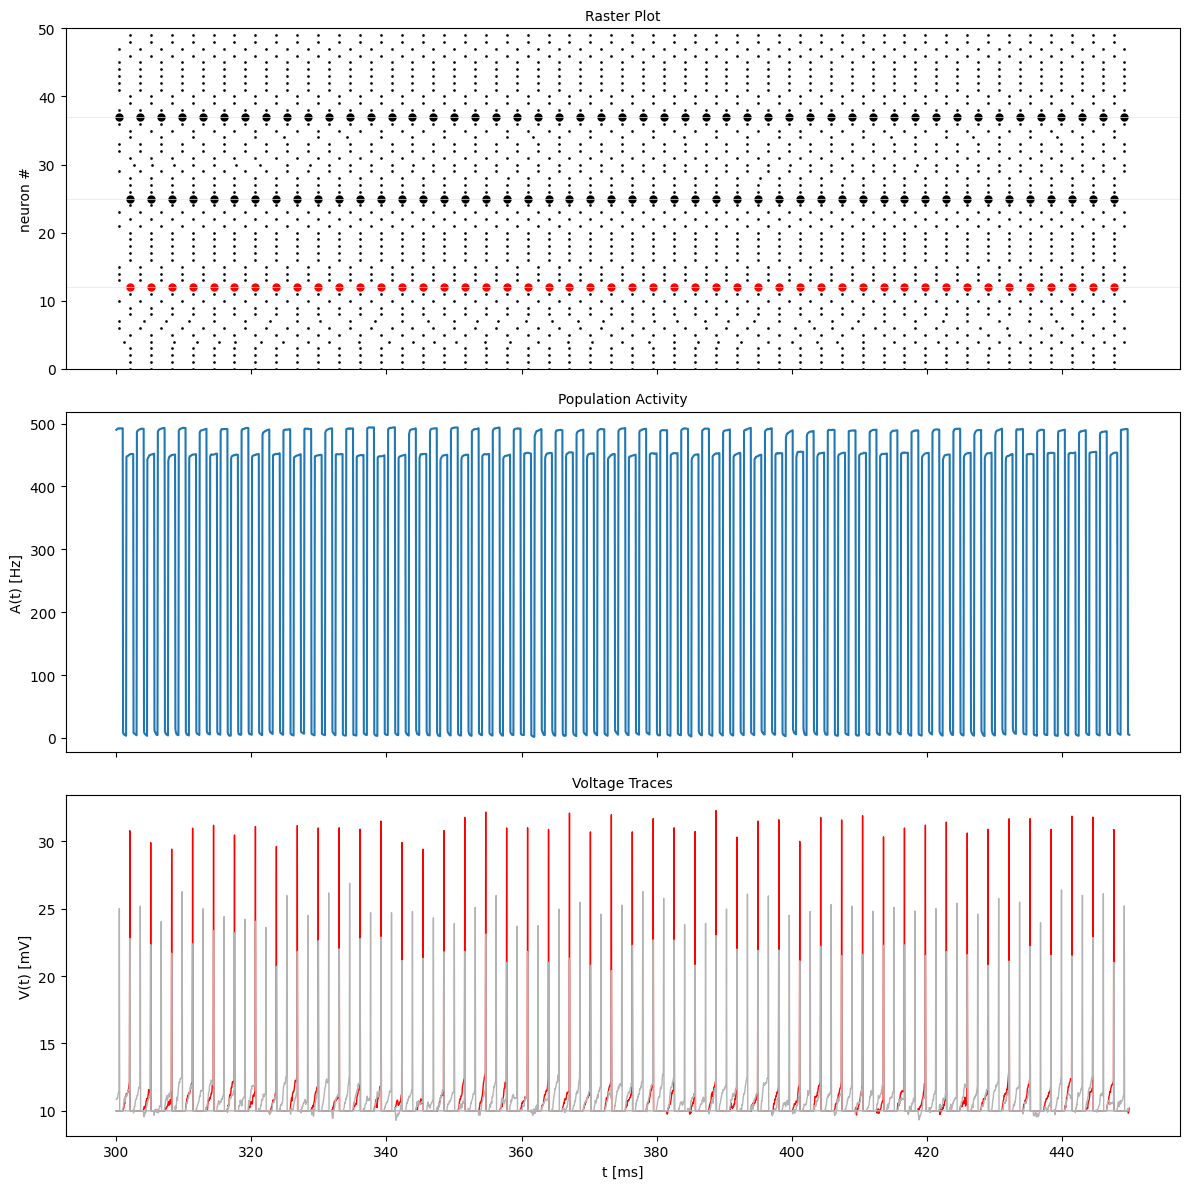

In [36]:
DEA.show_simulation()

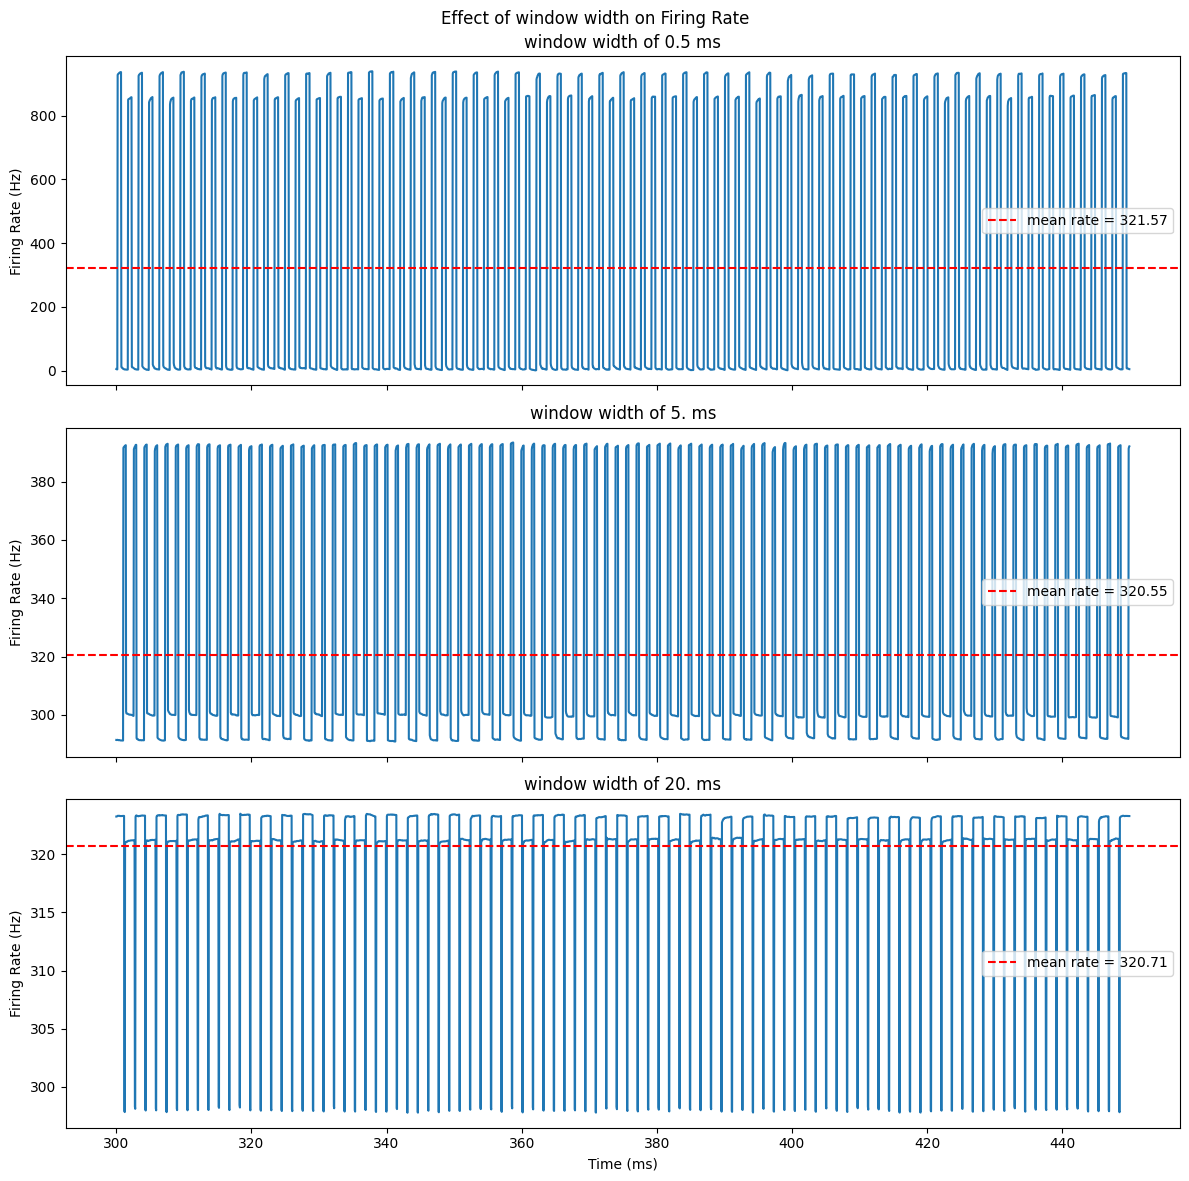

In [37]:
DEA.show_smoothed_rate()

In [38]:
DEA.get_spectrum()
DEA.get_freqres()


Sampling frequency fs		= 20000.0 Hz
Integration time constant	= 50. us
--------------------------------------------------------------
Welch frequency resolution			= 78.125 Hz
Welch frequency resolution (nperseg=256*8)	= 9.765625 Hz
Welch frequency 'resolution' (nfft=10000)	= 2.0 Hz
Welch frequency 'resolution' (nperseg=256*8 & nfft=10000)	= 2.0 Hz



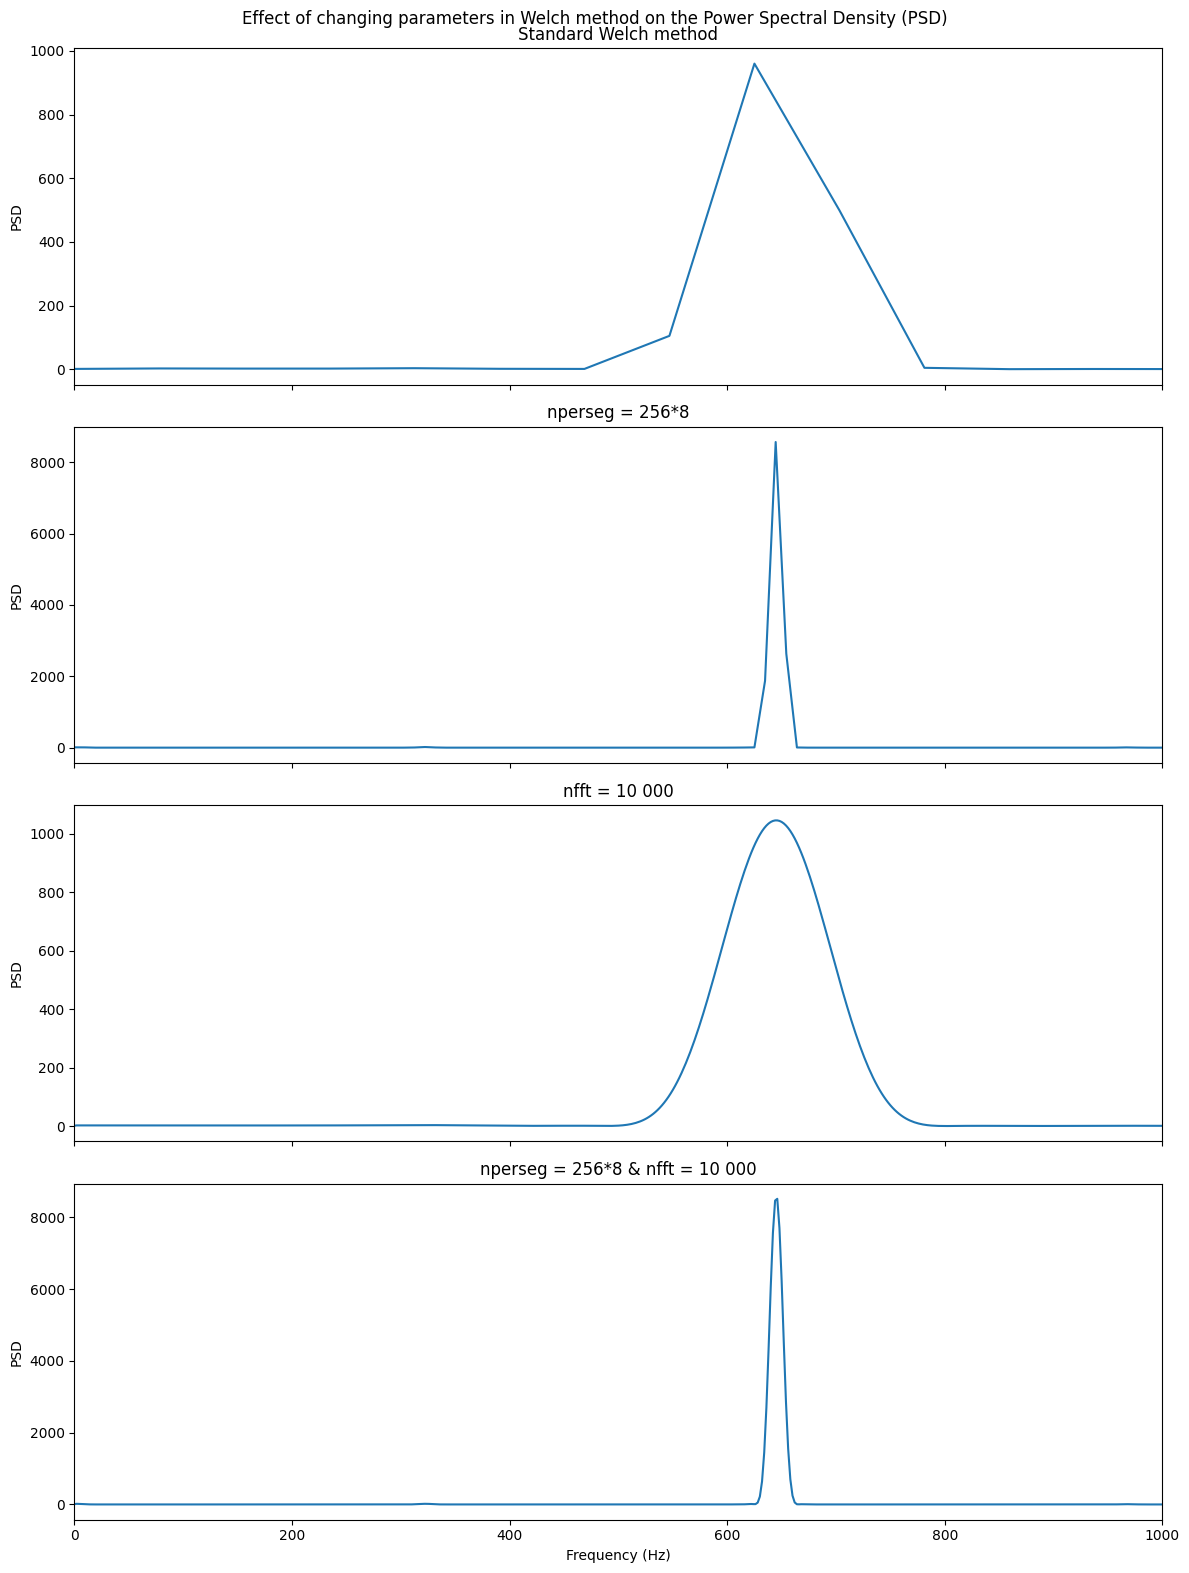

In [39]:
DEA.show_PSD()

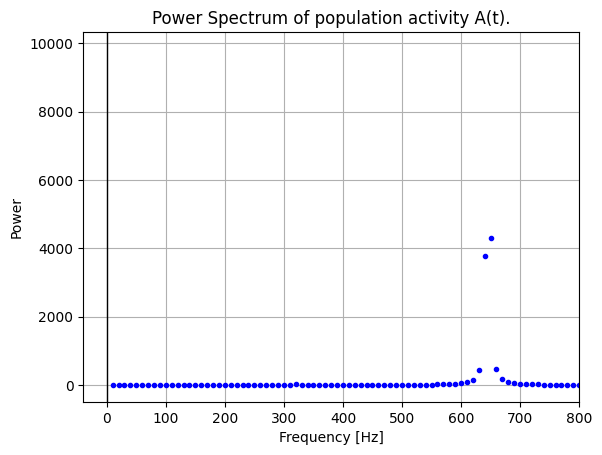

In [40]:
DEA.get_population_activity(f_lim = 800)

<div class="alert alert-success">
<span style="color:black">

**3A Answer** 
    
The parameter $g$ represents the inhibitory strength, while $\nu_{\text{extern}}$ denotes the firing frequency of the external neurons.

The network settles into a synchronous regular (SR) state when excitation dominates inhibition and synaptic time distributions are sharply peaked. In this state, neurons tend to synchronize almost fully into a few clusters, behaving as oscillators. The activity in this state appears to be very regular, with the group of excitatory and inhibitory neurons spiking in an alternating manner. The power spectrum also exhibits a sharp peak, occurring around 640 Hz, despite the mean firing rate being around 320 spikes/s. This is because two clusters, the inhibitory and excitatory, fire in an alternating pattern.

Overall, the network exhibits strong synchronization with regularly firing neurons when excitation dominates inhibition.
    

</span>

## B : g = 6, $\nu_{extern}/\nu_{threshold} = 2$ 

In [41]:
g = 6
nu_threshold = LIF_spiking_network.FIRING_THRESHOLD / (N_extern * w0 * LIF_spiking_network.MEMBRANE_TIME_SCALE)
nu_extern = 2*nu_threshold

DEB = DynamicsExplorer(g, nu_extern)
DEB.simulate()

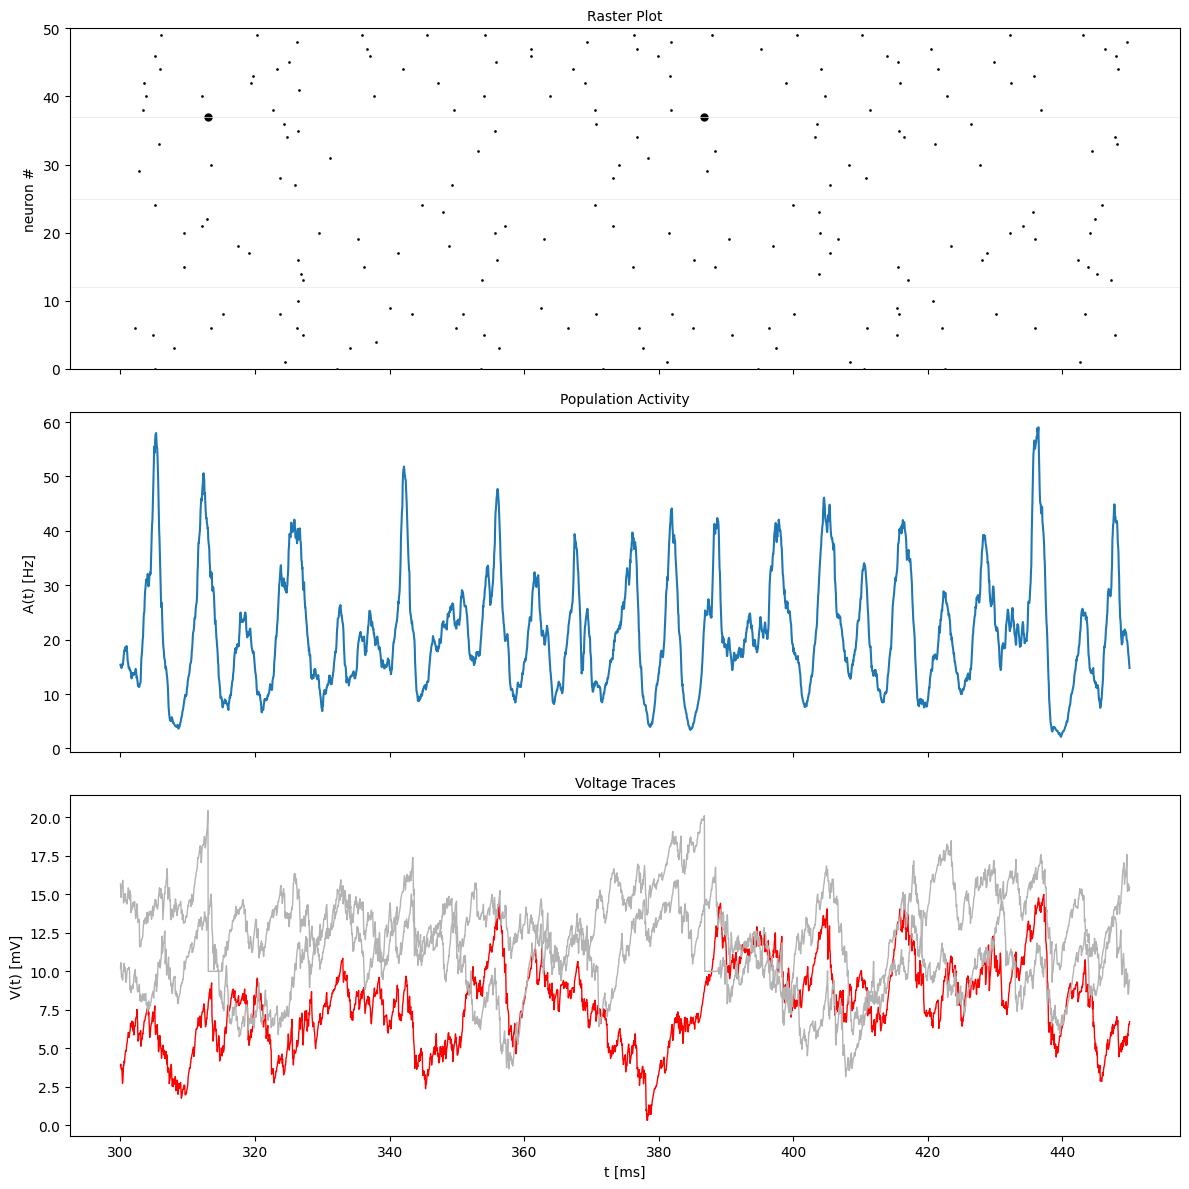

In [42]:
DEB.show_simulation()

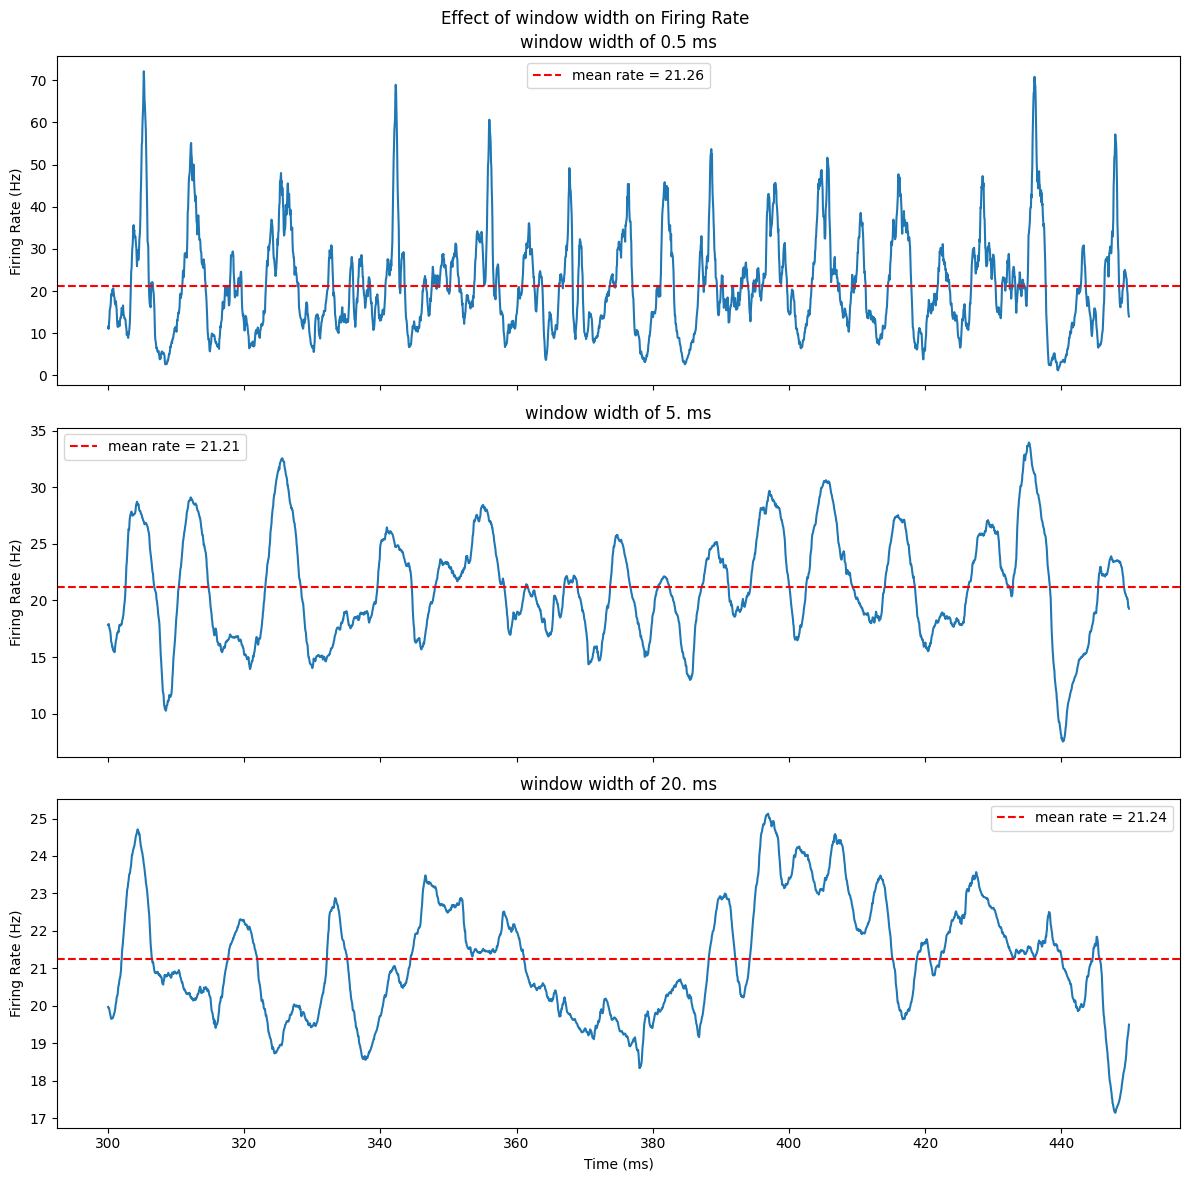

In [43]:
DEB.show_smoothed_rate()

In [44]:
DEB.get_spectrum()
DEB.get_freqres()


Sampling frequency fs		= 20000.0 Hz
Integration time constant	= 50. us
--------------------------------------------------------------
Welch frequency resolution			= 78.125 Hz
Welch frequency resolution (nperseg=256*8)	= 9.765625 Hz
Welch frequency 'resolution' (nfft=10000)	= 2.0 Hz
Welch frequency 'resolution' (nperseg=256*8 & nfft=10000)	= 2.0 Hz



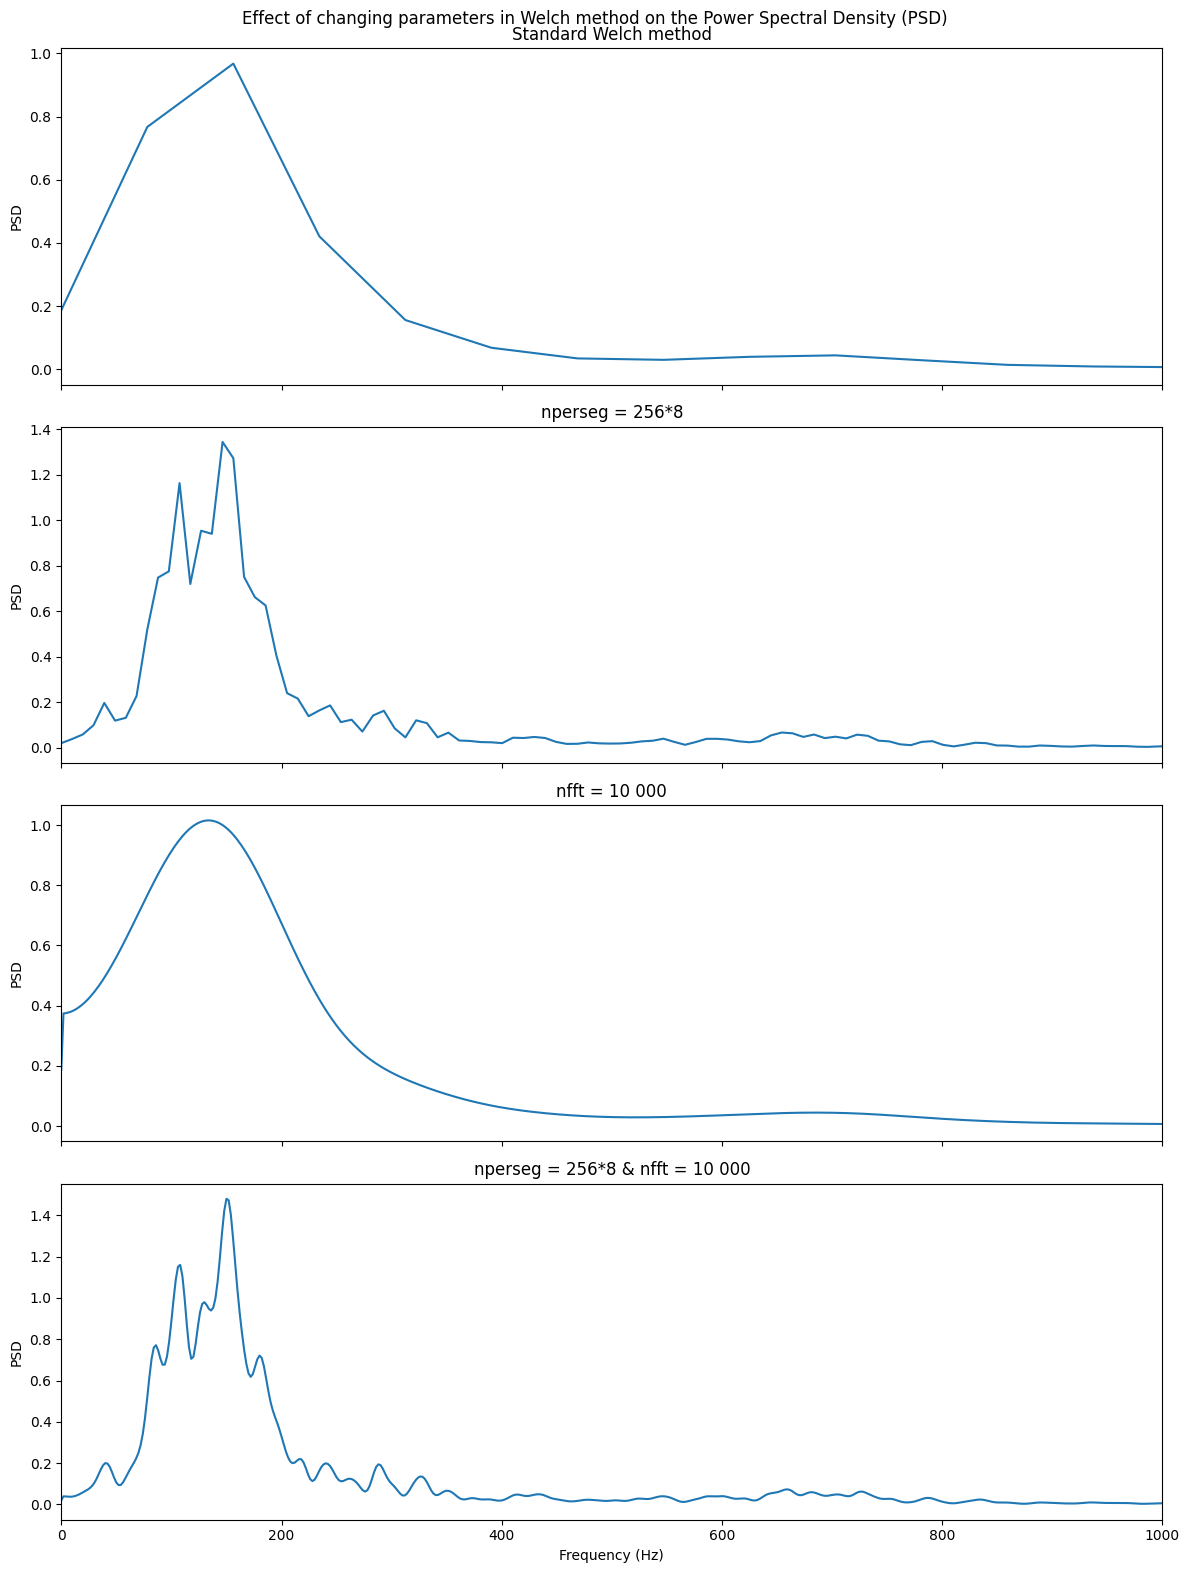

In [45]:
DEB.show_PSD()

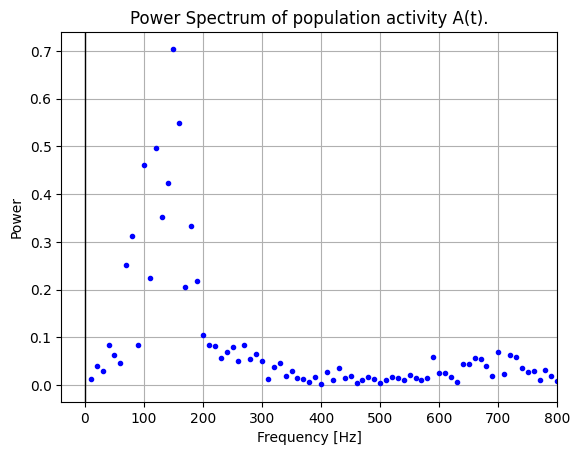

In [46]:
DEB.get_population_activity(f_lim = 800)

<div class="alert alert-success">
<span style="color:black">

**3B Answer** 
    
The results show a similar pattern to the parameters used in exercise 2, with a similarity observed among the spiking patterns of the different neurons. We thus conclude that this similarity probably depends on the value of $g$ the most.

This simulation induces the neurons into an asynchronous irregular state. The oscillations of the power spectrum are strongly damped.

Spiking becomes irregular due to the increased importance of the inhibitory population (increasing $g$ from 3 to 6).

For this combination of parameters, the system settles into a state where global activity exhibits strongly damped oscillations, and neurons fire irregularly. Hence, inhibition dominates, and the external frequency is moderate. The mean rate is much lower than in the previous cases (around 23 Hz). The power spectrum is damped.



</span>

## C : g = 4.5, $\nu_{extern}/\nu_{threshold} = 0.95$

In [47]:
g = 4.5
nu_threshold = LIF_spiking_network.FIRING_THRESHOLD / (N_extern * w0 * LIF_spiking_network.MEMBRANE_TIME_SCALE)
nu_extern = 0.95*nu_threshold

DEC = DynamicsExplorer(g, nu_extern)
DEC.simulate()

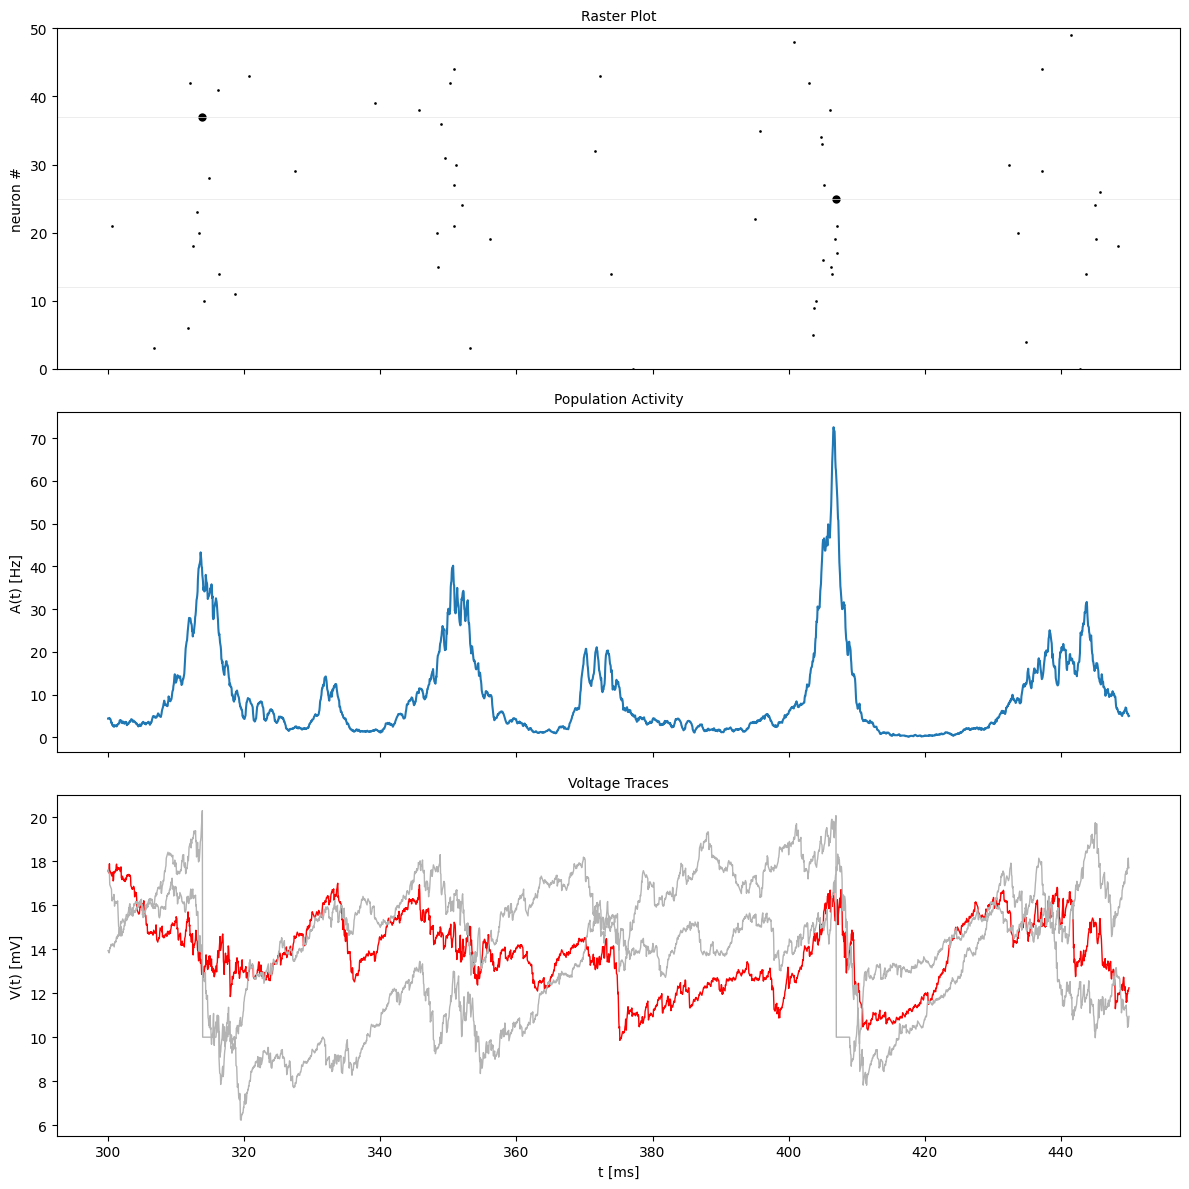

In [48]:
DEC.show_simulation()

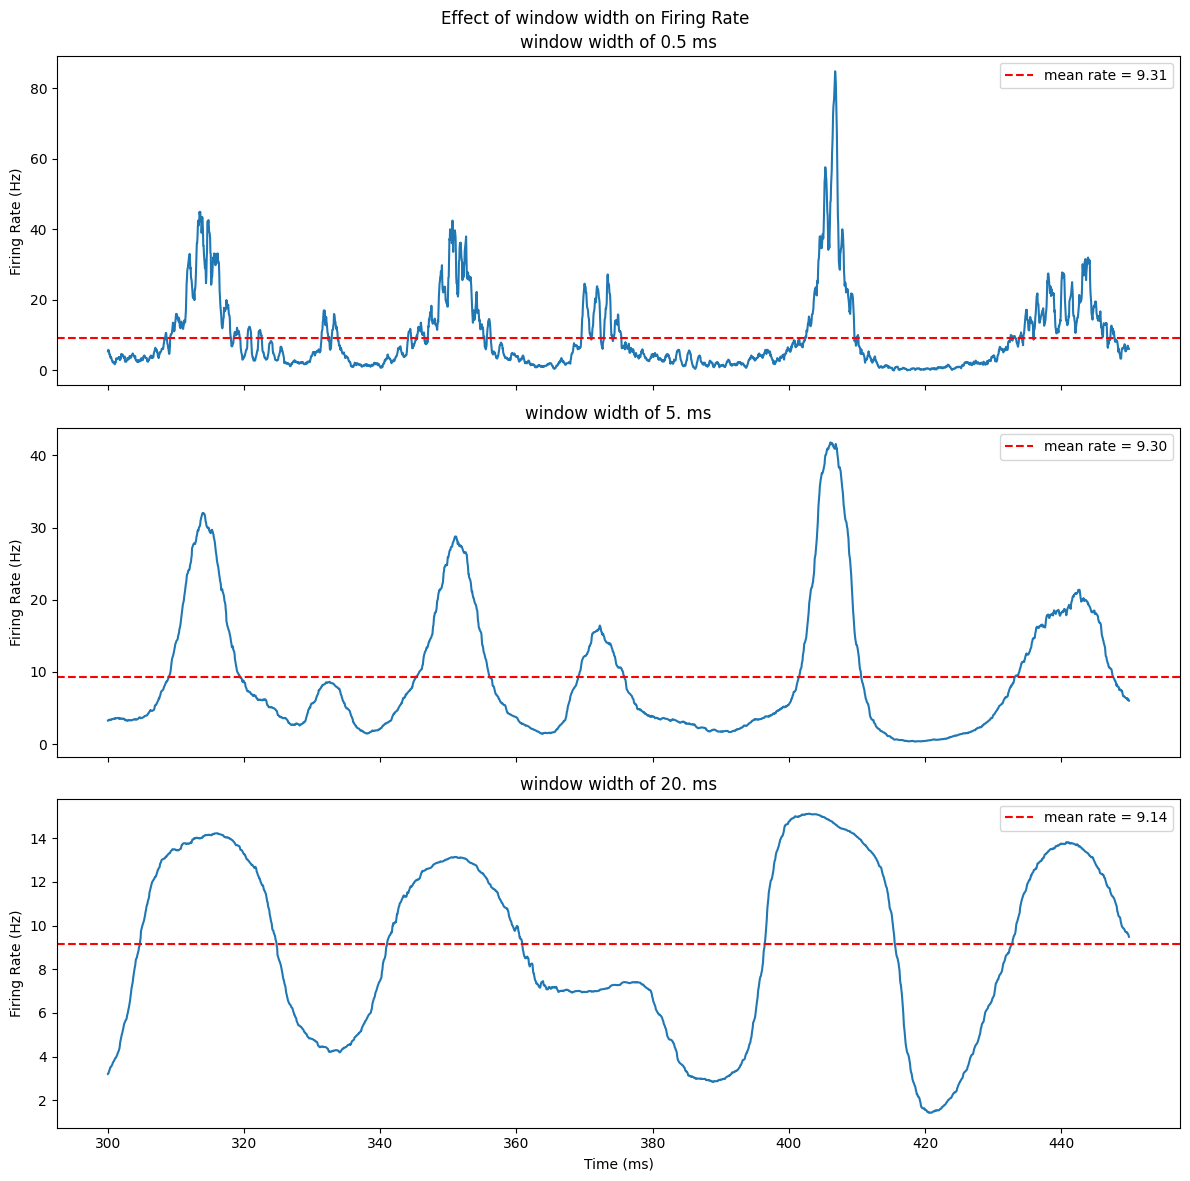

In [49]:
DEC.show_smoothed_rate()

In [50]:
DEC.get_spectrum()
DEC.get_freqres()


Sampling frequency fs		= 20000.0 Hz
Integration time constant	= 50. us
--------------------------------------------------------------
Welch frequency resolution			= 78.125 Hz
Welch frequency resolution (nperseg=256*8)	= 9.765625 Hz
Welch frequency 'resolution' (nfft=10000)	= 2.0 Hz
Welch frequency 'resolution' (nperseg=256*8 & nfft=10000)	= 2.0 Hz



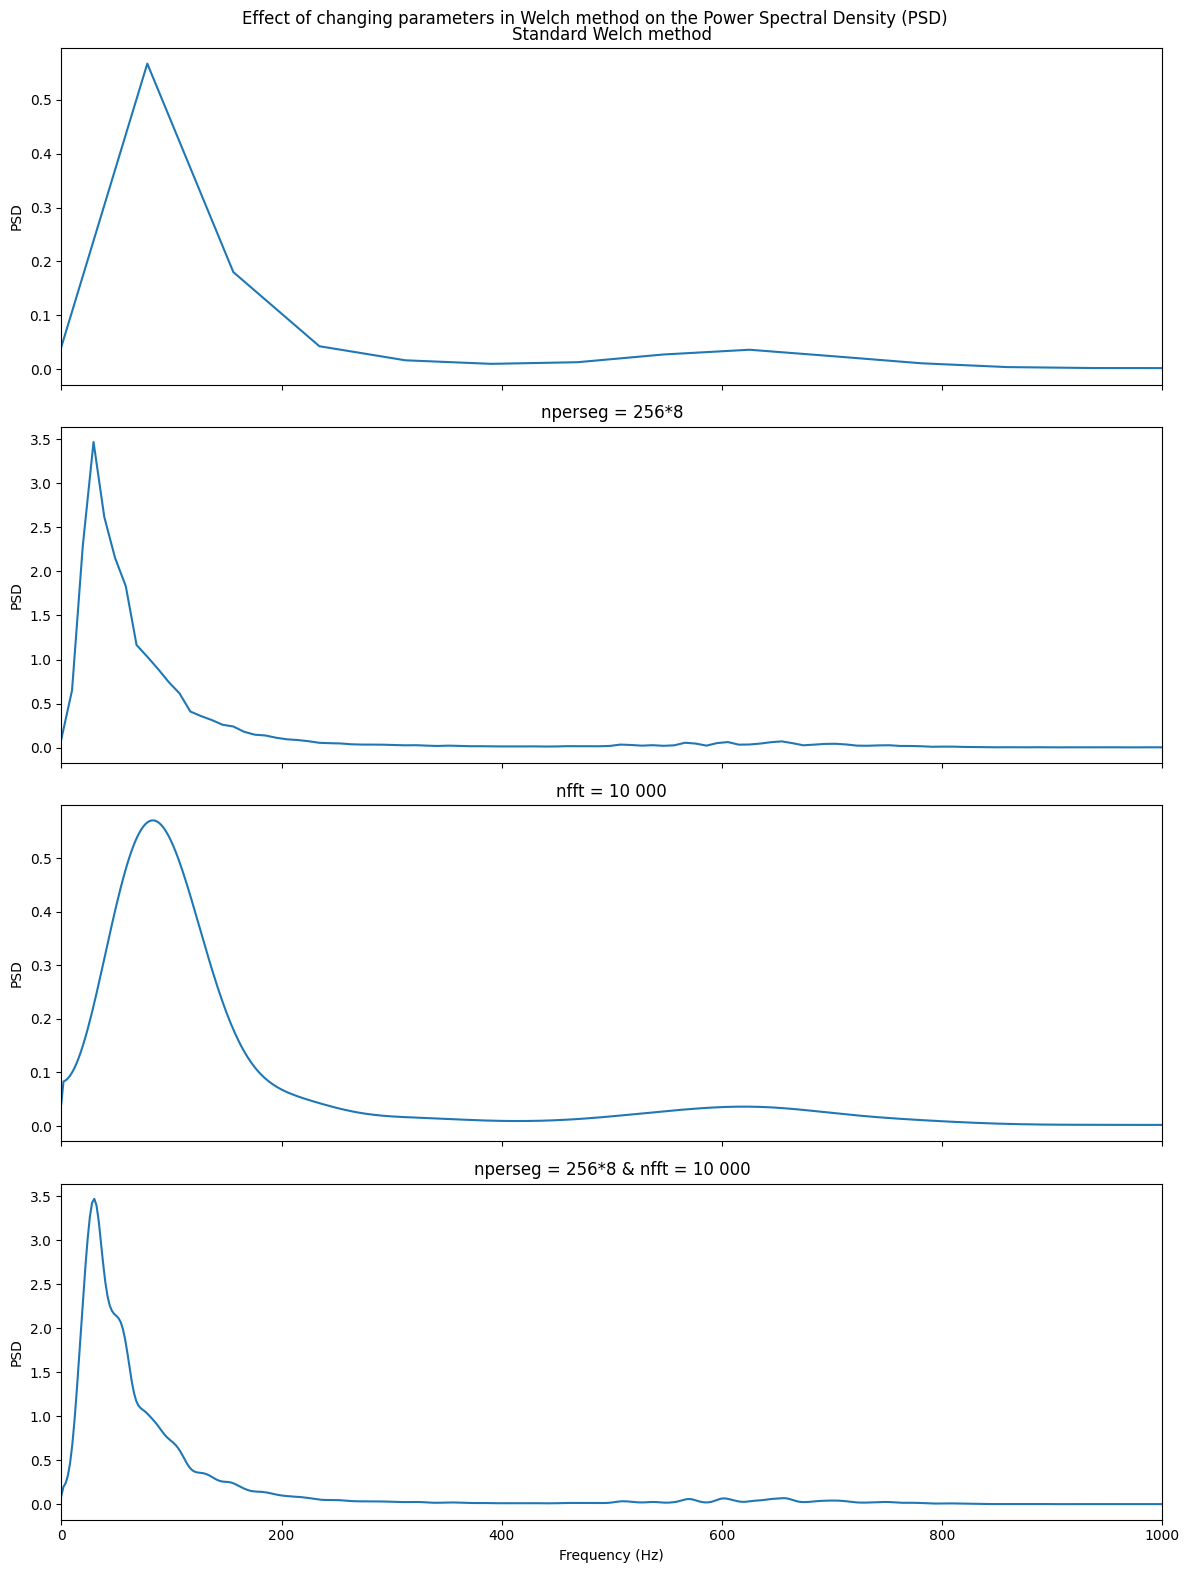

In [51]:
DEC.show_PSD()

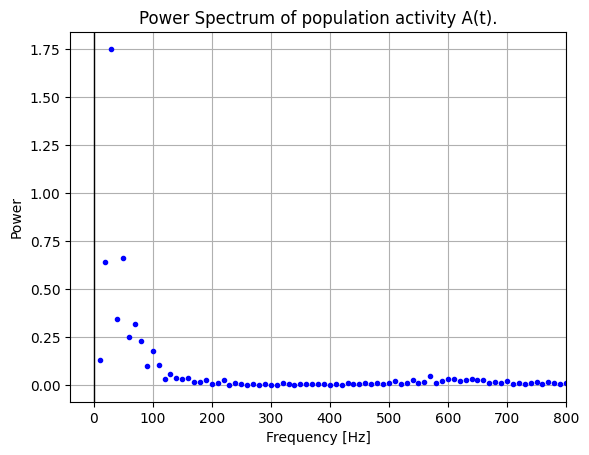

In [52]:
DEC.get_population_activity(f_lim = 800)

<div class="alert alert-success">
<span style="color:black">

**3C Answer** 
    
The combination of a moderate $g$ with a very low $\nu_{\text{extern}}$ results in a synchronous irregular state with slow oscillations. There are very low individual neuron firing rates when inhibition dominates and the $\nu_{\text{extern}}$  is smaller than but close to $\nu_{\text{threshold}}$ . The mean spiking rate is even lower, around 7.5 Hz.

After spiking, the inhibitory neurons dominate again and all spiking stops. After some time, the influence of the external neurons will build up again.

In conclusion, there is synchronicity because there is spiking at the same time, but there are large intervals between the spiking events.
    
</span>